# CNN Model Training Notebook

This notebook mirrors the experimental workflow of the RNN notebook. It performs hyper-parameter searches, model training, and final evaluation for the CNN architecture.

In [2]:
!pip install neurokit2

   ---------------------------------------- 0.0/708.4 kB ? eta -:--:--
   ---------------------------------------- 708.4/708.4 kB 8.2 MB/s  0:00:00



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import random
import time

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchmetrics import AUROC, F1Score, Precision, Recall

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ParameterSampler, StratifiedKFold, train_test_split
import seaborn as sns
from sklearn.metrics import f1_score


from utils.cnn_models import ECG_CNN_Classifier
from utils.data import calculate_class_weights, split_x_y
from utils.logging import log_to_csv, log_to_json
from utils.preprocessing import Preprocessing
from utils.torch_classes import ECG_Dataset, EarlyStopping
from utils.train import test_loop, train_and_eval_model, val_loop


In [4]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True


In [14]:
# Load preprocessed training and validation data
train_val_path = "data/ecg_train_dataset.npz"
train_val_data = np.load(train_val_path)

X = train_val_data["X"]
y = train_val_data["y"]
print(X)
print(y)


[[ 3.1731707e-01  3.2644907e-01  3.2704669e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.7335706e-01  3.6943287e-01  3.7251601e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.0673460e-01  1.0735919e-01  1.0894809e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 5.1565772e-01  5.1755744e-01  5.1816529e-01 ...  8.0453027e-03
   1.0090820e-02  2.0305386e-03]
 [ 4.2283586e-01  3.5471672e-01  2.8312129e-01 ...  2.5781192e-04
   3.1452603e-04  6.6019529e-03]
 [-2.3482393e-03 -3.0317274e-03  4.3378612e-03 ... -3.0386189e-03
   2.0434889e-03 -1.2676485e-03]]
[0 0 0 ... 4 4 0]


In [15]:
# Stratified K-Fold setup
K = 5
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)


In [17]:
# Hyper-parameter search space for the CNN experiments
EXPERIMENTS = 16

param_grid = {
    "conv_channels": [
        (32, 64, 128),
        (64, 128, 256),
        (32, 64, 64),
        (64, 64, 128),
    ],
    "kernel_sizes": [
        (7, 5, 3),
        (9, 7, 5),
        (5, 5, 3),
    ],
    "pool_kernel_sizes": [
        (2, 2, 2),
        (2, 2, 1),
    ],
    "dropout": [0.1, 0.2, 0.3, 0.4],
    "fc_hidden_dim": [128, 256, None],
    "use_batch_norm": [True, False],
    "optimizer": ["Adam", "AdamW", "SGD"],
    "momentum": np.linspace(0.85, 0.95, 3).tolist(),
    "batch_size": [64, 128, 256],
    "learning_rate": np.logspace(-4, -3, num=5).tolist(),
    "weight_decay": np.logspace(-5, -3, num=5).tolist(),
}

configs = list(
    ParameterSampler(
        param_grid,
        n_iter=EXPERIMENTS,
        random_state=42,
    )
)


In [ ]:
LOG_FOLDER = "cnn_random_search"
EPOCHS = 30

PATIENCE = 6
DELTA = 1e-4

NUM_CLASSES = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

results_summary_json = []
results_summary_csv = []

for i, params in enumerate(configs, start=1):
    print(f"-------------- Experiment {i}/{len(configs)} ----------------")
    try:
        params_copy = dict(params)

        batch_size = params_copy["batch_size"]
        optimizer_name = params_copy["optimizer"]
        conv_channels = params_copy["conv_channels"]
        kernel_sizes = params_copy["kernel_sizes"]
        pool_kernel_sizes = params_copy["pool_kernel_sizes"]
        dropout = params_copy["dropout"]
        fc_hidden_dim = params_copy["fc_hidden_dim"]
        use_batch_norm = params_copy["use_batch_norm"]

        momentum = params_copy["momentum"]
        learning_rate = params_copy["learning_rate"]
        weight_decay = params_copy["weight_decay"]

        fold_metrics = []

        for fold, (train_index, val_index) in enumerate(kfold.split(X, y), start=1):
            print(f"--------- Fold {fold}/{K} ---------")

            X_train_fold, y_train_fold = X[train_index], y[train_index]
            X_val_fold, y_val_fold = X[val_index], y[val_index]

            train_dataset = ECG_Dataset(X_train_fold, y_train_fold)
            val_dataset = ECG_Dataset(X_val_fold, y_val_fold)

            _, class_weights = calculate_class_weights(y_train_fold)
            sample_weights = np.array(class_weights)[y_train_fold]
            weighted_sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights),
                replacement=True,
            )

            train_dataloader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                sampler=weighted_sampler,
                shuffle=False,
                num_workers=2,
                persistent_workers=True,
                pin_memory=True,
            )

            val_dataloader = DataLoader(
                dataset=val_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2,
                persistent_workers=True,
                pin_memory=True,
            )

            model = ECG_CNN_Classifier(
                num_classes=NUM_CLASSES,
                in_channels=1,
                conv_channels=conv_channels,
                kernel_sizes=kernel_sizes,
                pool_kernel_sizes=pool_kernel_sizes,
                dropout=dropout,
                fc_hidden_dim=fc_hidden_dim,
                use_batch_norm=use_batch_norm,
            )
            model.to(device)

            if optimizer_name == "Adam":
                optimizer = torch.optim.Adam(
                    params=model.parameters(),
                    lr=learning_rate,
                    weight_decay=weight_decay,
                )
            elif optimizer_name == "AdamW":
                optimizer = torch.optim.AdamW(
                    params=model.parameters(),
                    lr=learning_rate,
                    weight_decay=weight_decay,
                )
            elif optimizer_name == "SGD":
                optimizer = torch.optim.SGD(
                    params=model.parameters(),
                    lr=learning_rate,
                    momentum=momentum,
                    weight_decay=weight_decay,
                )
            else:
                raise ValueError(f"Unknown optimizer: {optimizer_name}")

            loss_fn = nn.CrossEntropyLoss()
            early_stopper = EarlyStopping(
                patience=PATIENCE,
                delta=DELTA,
                checkpoint_path=f"{LOG_FOLDER}/checkpoints/experiment_{i}/fold_{fold}.pt",
                verbose=True,
            )

            precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
            recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
            f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
            auc_metric = AUROC(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)

            start = time.time()
            history = train_and_eval_model(
                model=model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                epochs=EPOCHS,
                device=device,
                early_stopper=early_stopper,
                debug=True,
                verbose=True,
                grad_clip=True,
                max_norm=1.0,
            )
            end = time.time()

            epochs_run = len(history["train_loss"])
            total_time = end - start
            time_per_epoch = total_time / epochs_run if epochs_run > 0 else 0.0

            checkpoint = torch.load(early_stopper.checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint["model_state_dict"])

            val_data = val_loop(
                model=model,
                val_dataloader=val_dataloader,
                loss_fn=loss_fn,
                device=device,
            )

            val_pred = torch.cat(val_data["y_pred"])
            val_true = torch.cat(val_data["y_true"])
            val_logits = torch.cat(val_data["y_pred_logits"])

            fold_precision = precision_metric(val_pred.to(device), val_true.to(device)).item()
            fold_recall = recall_metric(val_pred.to(device), val_true.to(device)).item()
            fold_f1 = f1_metric(val_pred.to(device), val_true.to(device)).item()
            fold_auc = auc_metric(val_logits.to(device), val_true.to(device)).item()

            fold_metrics.append(
                {
                    "fold": fold,
                    "precision": fold_precision,
                    "recall": fold_recall,
                    "f1": fold_f1,
                    "auc": fold_auc,
                    "time_per_epoch": time_per_epoch,
                    "epochs_run": epochs_run,
                    "total_epochs": EPOCHS,
                }
            )

            print(f"Fold {fold}: F1={fold_f1:.3f} | AUC={fold_auc:.3f}")

        avg_precision = np.mean([m["precision"] for m in fold_metrics])
        avg_recall = np.mean([m["recall"] for m in fold_metrics])
        avg_f1 = np.mean([m["f1"] for m in fold_metrics])
        avg_auc = np.mean([m["auc"] for m in fold_metrics])
        avg_time_per_epoch = np.mean([m["time_per_epoch"] for m in fold_metrics])
        avg_epochs_run = np.mean([m["epochs_run"] for m in fold_metrics])

        results_summary_csv.append(
            {
                "experiment": i,
                "avg_precision": avg_precision,
                "avg_recall": avg_recall,
                "avg_f1": avg_f1,
                "avg_auc": avg_auc,
                "avg_time_per_epoch": avg_time_per_epoch,
                "avg_epochs_run": avg_epochs_run,
                "total_epochs": EPOCHS,
            }
        )

        if optimizer_name != "SGD":
            params_copy["momentum"] = None

        results_summary_json.append(
            {
                "experiment": i,
                **params_copy,
                "fold_metrics": fold_metrics,
            }
        )

        log_to_csv(f"{LOG_FOLDER}/results.csv", results_summary_csv)
        log_to_json(f"{LOG_FOLDER}/results.json", results_summary_json)

        print(f"Experiment {i} Done: Avg F1={avg_f1:.3f}, Avg AUC={avg_auc:.3f}")

    except Exception as exc:
        print(f"Experiment {i} failed: {exc}")


-------------- Experiment 1/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4256)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.867 | Val Loss:  1.426
Best Val Loss:  1.426
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.632 | Val Loss:  1.550
Best Val Loss:  1.426
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.559 | Val Loss:  1.842
Best Val Loss:  1.426
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.4256 -->  1.3648)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.510 | Val Loss:  1.365
Best Val Loss:  1.365
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.478 | Val Loss:  1.562
Best Val Loss:  1.365
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3648 -->  1.1309)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.455 | Val Loss:  1.131
Best Val Loss:  1.131
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.437 | Val Loss:  1.298
Best Val Loss:  1.131
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1309 -->  1.0336)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.417 | Val Loss:  1.034
Best Val Loss:  1.034
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0336 -->  1.0012)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.404 | Val Loss:  1.001
Best Val Loss:  1.001
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.393 | Val Loss:  1.173
Best Val Loss:  1.001
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.381 | Val Loss:  1.383
Best Val Loss:  1.001
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.373 | Val Loss:  1.005
Best Val Loss:  1.001
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.365 | Val Loss:  1.140
Best Val Loss:  1.001
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.354 | Val Loss:  1.399
Best Val Loss:  1.001
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.346 | Val Loss:  1.039
Best Val Loss:  1.001
-------------------------------------------------
Stopping Early at epoch 15 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 1: F1=0.383 | AUC=0.925
--------- Fold 2/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.3446)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.865 | Val Loss:  1.345
Best Val Loss:  1.345
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3446 -->  0.9895)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.630 | Val Loss:  0.990
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9895 -->  0.6682)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.555 | Val Loss:  0.668
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.507 | Val Loss:  0.977
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.470 | Val Loss:  1.246
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.449 | Val Loss:  0.941
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.430 | Val Loss:  1.222
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.413 | Val Loss:  1.101
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.399 | Val Loss:  1.460
Best Val Loss:  0.668
-------------------------------------------------
Stopping Early at epoch 9 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 2: F1=0.433 | AUC=0.926
--------- Fold 3/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.9429)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.874 | Val Loss:  1.943
Best Val Loss:  1.943
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.9429 -->  1.3924)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.640 | Val Loss:  1.392
Best Val Loss:  1.392
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3924 -->  0.9343)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.565 | Val Loss:  0.934
Best Val Loss:  0.934
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.514 | Val Loss:  1.033
Best Val Loss:  0.934
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.480 | Val Loss:  1.199
Best Val Loss:  0.934
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.456 | Val Loss:  1.121
Best Val Loss:  0.934
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.433 | Val Loss:  1.264
Best Val Loss:  0.934
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.418 | Val Loss:  1.170
Best Val Loss:  0.934
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.405 | Val Loss:  1.414
Best Val Loss:  0.934
-------------------------------------------------
Stopping Early at epoch 9 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 3: F1=0.312 | AUC=0.908
--------- Fold 4/5 ---------


Training:   0%|          | 0/2080 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4569)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.878 | Val Loss:  1.457
Best Val Loss:  1.457
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.4569 -->  1.3054)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.632 | Val Loss:  1.305
Best Val Loss:  1.305
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.558 | Val Loss:  1.356
Best Val Loss:  1.305
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3054 -->  1.0969)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.504 | Val Loss:  1.097
Best Val Loss:  1.097
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.470 | Val Loss:  1.326
Best Val Loss:  1.097
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.447 | Val Loss:  1.443
Best Val Loss:  1.097
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0969 -->  1.0365)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.425 | Val Loss:  1.036
Best Val Loss:  1.036
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.405 | Val Loss:  1.153
Best Val Loss:  1.036
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0365 -->  1.0218)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.394 | Val Loss:  1.022
Best Val Loss:  1.022
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.379 | Val Loss:  1.159
Best Val Loss:  1.022
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.373 | Val Loss:  1.223
Best Val Loss:  1.022
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0218 -->  0.9231)
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.359 | Val Loss:  0.923
Best Val Loss:  0.923
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.356 | Val Loss:  1.114
Best Val Loss:  0.923
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.345 | Val Loss:  1.307
Best Val Loss:  0.923
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.341 | Val Loss:  1.043
Best Val Loss:  0.923
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.332 | Val Loss:  0.985
Best Val Loss:  0.923
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.331 | Val Loss:  1.175
Best Val Loss:  0.923
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9231 -->  0.9138)
Epoch 18 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.323 | Val Loss:  0.914
Best Val Loss:  0.914
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 19 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.319 | Val Loss:  0.970
Best Val Loss:  0.914
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9138 -->  0.8847)
Epoch 20 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.316 | Val Loss:  0.885
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 21 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.310 | Val Loss:  1.001
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 22 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.309 | Val Loss:  0.947
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 23 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.304 | Val Loss:  0.943
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 24 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.299 | Val Loss:  1.110
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 25 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.295 | Val Loss:  0.996
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8847 -->  0.8423)
Epoch 26 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.291 | Val Loss:  0.842
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8423 -->  0.8217)
Epoch 27 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.289 | Val Loss:  0.822
Best Val Loss:  0.822
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 28 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.285 | Val Loss:  1.213
Best Val Loss:  0.822
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 29 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.283 | Val Loss:  1.015
Best Val Loss:  0.822
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 30 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.278 | Val Loss:  0.947
Best Val Loss:  0.822
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 4: F1=0.589 | AUC=0.959
--------- Fold 5/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.3236)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.880 | Val Loss:  1.324
Best Val Loss:  1.324
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3236 -->  0.9386)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.638 | Val Loss:  0.939
Best Val Loss:  0.939
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9386 -->  0.7182)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.560 | Val Loss:  0.718
Best Val Loss:  0.718
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.512 | Val Loss:  0.808
Best Val Loss:  0.718
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.472 | Val Loss:  1.042
Best Val Loss:  0.718
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.451 | Val Loss:  0.926
Best Val Loss:  0.718
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.430 | Val Loss:  0.954
Best Val Loss:  0.718
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.416 | Val Loss:  1.080
Best Val Loss:  0.718
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.402 | Val Loss:  1.076
Best Val Loss:  0.718
-------------------------------------------------
Stopping Early at epoch 9 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 5: F1=0.371 | AUC=0.909
Experiment 1 Done: Avg F1=0.418, Avg AUC=0.925
-------------- Experiment 2/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.5394)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.491 | Val Loss:  1.539
Best Val Loss:  1.539
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5394 -->  1.5031)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.357 | Val Loss:  1.503
Best Val Loss:  1.503
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5031 -->  1.4546)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.261 | Val Loss:  1.455
Best Val Loss:  1.455
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4546 -->  1.4423)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.182 | Val Loss:  1.442
Best Val Loss:  1.442
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4423 -->  1.3867)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  1.125 | Val Loss:  1.387
Best Val Loss:  1.387
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3867 -->  1.3459)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  1.074 | Val Loss:  1.346
Best Val Loss:  1.346
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3459 -->  1.2895)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  1.032 | Val Loss:  1.289
Best Val Loss:  1.289
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2895 -->  1.2172)
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.991 | Val Loss:  1.217
Best Val Loss:  1.217
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2172 -->  1.1814)
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.956 | Val Loss:  1.181
Best Val Loss:  1.181
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1814 -->  1.1521)
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.923 | Val Loss:  1.152
Best Val Loss:  1.152
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1521 -->  1.1494)
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.895 | Val Loss:  1.149
Best Val Loss:  1.149
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1494 -->  1.1300)
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.875 | Val Loss:  1.130
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.855 | Val Loss:  1.171
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 14 / 30 | Current LR: 0.0001
Train Loss:  0.836 | Val Loss:  1.167
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 15 / 30 | Current LR: 0.0001
Train Loss:  0.818 | Val Loss:  1.158
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 16 / 30 | Current LR: 0.0001
Train Loss:  0.805 | Val Loss:  1.222
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 17 / 30 | Current LR: 0.0001
Train Loss:  0.790 | Val Loss:  1.206
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 18 / 30 | Current LR: 0.0001
Train Loss:  0.781 | Val Loss:  1.215
Best Val Loss:  1.130
-------------------------------------------------
Stopping Early at epoch 18 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.256 | AUC=0.854
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.5753)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.485 | Val Loss:  1.575
Best Val Loss:  1.575
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5753 -->  1.5126)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.342 | Val Loss:  1.513
Best Val Loss:  1.513
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5126 -->  1.4737)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.250 | Val Loss:  1.474
Best Val Loss:  1.474
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4737 -->  1.4383)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.167 | Val Loss:  1.438
Best Val Loss:  1.438
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4383 -->  1.3955)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  1.102 | Val Loss:  1.396
Best Val Loss:  1.396
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3955 -->  1.3827)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  1.042 | Val Loss:  1.383
Best Val Loss:  1.383
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3827 -->  1.3209)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.986 | Val Loss:  1.321
Best Val Loss:  1.321
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3209 -->  1.3172)
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.946 | Val Loss:  1.317
Best Val Loss:  1.317
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3172 -->  1.3140)
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.914 | Val Loss:  1.314
Best Val Loss:  1.314
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3140 -->  1.2946)
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.884 | Val Loss:  1.295
Best Val Loss:  1.295
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2946 -->  1.2848)
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.864 | Val Loss:  1.285
Best Val Loss:  1.285
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.843 | Val Loss:  1.303
Best Val Loss:  1.285
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.829 | Val Loss:  1.327
Best Val Loss:  1.285
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.0001
Train Loss:  0.813 | Val Loss:  1.346
Best Val Loss:  1.285
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.0001
Train Loss:  0.802 | Val Loss:  1.425
Best Val Loss:  1.285
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.0001
Train Loss:  0.791 | Val Loss:  1.377
Best Val Loss:  1.285
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.0001
Train Loss:  0.776 | Val Loss:  1.454
Best Val Loss:  1.285
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.208 | AUC=0.861
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.5309)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.496 | Val Loss:  1.531
Best Val Loss:  1.531
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5309 -->  1.5054)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.372 | Val Loss:  1.505
Best Val Loss:  1.505
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5054 -->  1.4431)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.286 | Val Loss:  1.443
Best Val Loss:  1.443
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4431 -->  1.3967)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.212 | Val Loss:  1.397
Best Val Loss:  1.397
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3967 -->  1.3141)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  1.150 | Val Loss:  1.314
Best Val Loss:  1.314
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3141 -->  1.2006)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  1.093 | Val Loss:  1.201
Best Val Loss:  1.201
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2006 -->  1.1286)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  1.043 | Val Loss:  1.129
Best Val Loss:  1.129
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1286 -->  1.0641)
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  1.002 | Val Loss:  1.064
Best Val Loss:  1.064
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0641 -->  1.0514)
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.966 | Val Loss:  1.051
Best Val Loss:  1.051
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0514 -->  1.0208)
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.934 | Val Loss:  1.021
Best Val Loss:  1.021
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0208 -->  1.0087)
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.909 | Val Loss:  1.009
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0087 -->  1.0044)
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.886 | Val Loss:  1.004
Best Val Loss:  1.004
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.856 | Val Loss:  1.005
Best Val Loss:  1.004
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 14 / 30 | Current LR: 0.0001
Train Loss:  0.841 | Val Loss:  1.010
Best Val Loss:  1.004
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 15 / 30 | Current LR: 0.0001
Train Loss:  0.824 | Val Loss:  1.006
Best Val Loss:  1.004
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 16 / 30 | Current LR: 0.0001
Train Loss:  0.806 | Val Loss:  1.018
Best Val Loss:  1.004
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 17 / 30 | Current LR: 0.0001
Train Loss:  0.798 | Val Loss:  1.013
Best Val Loss:  1.004
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 18 / 30 | Current LR: 0.0001
Train Loss:  0.790 | Val Loss:  1.031
Best Val Loss:  1.004
-------------------------------------------------
Stopping Early at epoch 18 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.259 | AUC=0.876
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.5346)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.505 | Val Loss:  1.535
Best Val Loss:  1.535
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5346 -->  1.4686)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.384 | Val Loss:  1.469
Best Val Loss:  1.469
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4686 -->  1.4167)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.289 | Val Loss:  1.417
Best Val Loss:  1.417
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4167 -->  1.3787)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.214 | Val Loss:  1.379
Best Val Loss:  1.379
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3787 -->  1.3162)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  1.153 | Val Loss:  1.316
Best Val Loss:  1.316
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3162 -->  1.2300)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  1.101 | Val Loss:  1.230
Best Val Loss:  1.230
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2300 -->  1.1536)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  1.056 | Val Loss:  1.154
Best Val Loss:  1.154
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1536 -->  1.0797)
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  1.009 | Val Loss:  1.080
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0797 -->  1.0171)
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.970 | Val Loss:  1.017
Best Val Loss:  1.017
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0171 -->  0.9895)
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.942 | Val Loss:  0.989
Best Val Loss:  0.989
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9895 -->  0.9611)
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.908 | Val Loss:  0.961
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.884 | Val Loss:  0.995
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.861 | Val Loss:  0.994
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.0001
Train Loss:  0.842 | Val Loss:  0.984
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.0001
Train Loss:  0.827 | Val Loss:  0.997
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.0001
Train Loss:  0.808 | Val Loss:  1.063
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.0001
Train Loss:  0.799 | Val Loss:  1.009
Best Val Loss:  0.961
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.278 | AUC=0.864
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.5519)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.504 | Val Loss:  1.552
Best Val Loss:  1.552
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5519 -->  1.5225)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.377 | Val Loss:  1.523
Best Val Loss:  1.523
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5225 -->  1.4973)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.293 | Val Loss:  1.497
Best Val Loss:  1.497
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4973 -->  1.4644)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.223 | Val Loss:  1.464
Best Val Loss:  1.464
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4644 -->  1.4005)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  1.161 | Val Loss:  1.401
Best Val Loss:  1.401
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4005 -->  1.3311)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  1.101 | Val Loss:  1.331
Best Val Loss:  1.331
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3311 -->  1.2584)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  1.049 | Val Loss:  1.258
Best Val Loss:  1.258
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2584 -->  1.2092)
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.996 | Val Loss:  1.209
Best Val Loss:  1.209
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2092 -->  1.2052)
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.959 | Val Loss:  1.205
Best Val Loss:  1.205
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2052 -->  1.1918)
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.920 | Val Loss:  1.192
Best Val Loss:  1.192
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1918 -->  1.1657)
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.891 | Val Loss:  1.166
Best Val Loss:  1.166
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.867 | Val Loss:  1.185
Best Val Loss:  1.166
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.849 | Val Loss:  1.178
Best Val Loss:  1.166
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.0001
Train Loss:  0.832 | Val Loss:  1.219
Best Val Loss:  1.166
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.0001
Train Loss:  0.818 | Val Loss:  1.256
Best Val Loss:  1.166
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.0001
Train Loss:  0.806 | Val Loss:  1.233
Best Val Loss:  1.166
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.0001
Train Loss:  0.795 | Val Loss:  1.297
Best Val Loss:  1.166
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.219 | AUC=0.855
Experiment 2 Done: Avg F1=0.244, Avg AUC=0.862
-------------- Experiment 3/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  0.9682)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.066 | Val Loss:  0.968
Best Val Loss:  0.968
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9682 -->  0.8498)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.795 | Val Loss:  0.850
Best Val Loss:  0.850
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.699 | Val Loss:  0.854
Best Val Loss:  0.850
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8498 -->  0.8177)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.640 | Val Loss:  0.818
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.603 | Val Loss:  0.855
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.574 | Val Loss:  0.872
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.548 | Val Loss:  0.827
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.526 | Val Loss:  0.876
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8177 -->  0.8012)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.520 | Val Loss:  0.801
Best Val Loss:  0.801
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8012 -->  0.7498)
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.503 | Val Loss:  0.750
Best Val Loss:  0.750
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.495 | Val Loss:  0.824
Best Val Loss:  0.750
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.483 | Val Loss:  0.845
Best Val Loss:  0.750
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.475 | Val Loss:  0.939
Best Val Loss:  0.750
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.465 | Val Loss:  0.756
Best Val Loss:  0.750
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.455 | Val Loss:  0.779
Best Val Loss:  0.750
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.448 | Val Loss:  0.845
Best Val Loss:  0.750
-------------------------------------------------
Stopping Early at epoch 16 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.525 | AUC=0.956
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  0.8624)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.062 | Val Loss:  0.862
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8624 -->  0.7861)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.777 | Val Loss:  0.786
Best Val Loss:  0.786
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7861 -->  0.7116)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.690 | Val Loss:  0.712
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7116 -->  0.6799)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.639 | Val Loss:  0.680
Best Val Loss:  0.680
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.604 | Val Loss:  0.688
Best Val Loss:  0.680
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6799 -->  0.6405)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.580 | Val Loss:  0.641
Best Val Loss:  0.641
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.551 | Val Loss:  0.641
Best Val Loss:  0.641
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.533 | Val Loss:  0.711
Best Val Loss:  0.641
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6405 -->  0.6031)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.519 | Val Loss:  0.603
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.509 | Val Loss:  0.612
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.497 | Val Loss:  0.617
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.482 | Val Loss:  0.635
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.474 | Val Loss:  0.653
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6031 -->  0.5888)
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.466 | Val Loss:  0.589
Best Val Loss:  0.589
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.450 | Val Loss:  0.600
Best Val Loss:  0.589
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.446 | Val Loss:  0.684
Best Val Loss:  0.589
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.439 | Val Loss:  0.595
Best Val Loss:  0.589
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 18 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.433 | Val Loss:  0.612
Best Val Loss:  0.589
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.5888 -->  0.5783)
Epoch 19 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.426 | Val Loss:  0.578
Best Val Loss:  0.578
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 20 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.418 | Val Loss:  0.653
Best Val Loss:  0.578
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 21 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.414 | Val Loss:  0.613
Best Val Loss:  0.578
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 22 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.410 | Val Loss:  0.583
Best Val Loss:  0.578
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 23 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.403 | Val Loss:  0.649
Best Val Loss:  0.578
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 24 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.399 | Val Loss:  0.612
Best Val Loss:  0.578
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 25 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.397 | Val Loss:  0.633
Best Val Loss:  0.578
-------------------------------------------------
Stopping Early at epoch 25 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.570 | AUC=0.959
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  0.8711)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.035 | Val Loss:  0.871
Best Val Loss:  0.871
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8711 -->  0.7605)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.747 | Val Loss:  0.761
Best Val Loss:  0.761
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.666 | Val Loss:  0.816
Best Val Loss:  0.761
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.610 | Val Loss:  0.786
Best Val Loss:  0.761
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.578 | Val Loss:  0.764
Best Val Loss:  0.761
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7605 -->  0.7580)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.549 | Val Loss:  0.758
Best Val Loss:  0.758
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.532 | Val Loss:  0.775
Best Val Loss:  0.758
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.507 | Val Loss:  0.804
Best Val Loss:  0.758
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.503 | Val Loss:  0.780
Best Val Loss:  0.758
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.481 | Val Loss:  0.791
Best Val Loss:  0.758
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7580 -->  0.7485)
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.472 | Val Loss:  0.748
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.459 | Val Loss:  0.796
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.455 | Val Loss:  0.758
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.442 | Val Loss:  0.783
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.435 | Val Loss:  0.775
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.428 | Val Loss:  0.785
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.420 | Val Loss:  0.789
Best Val Loss:  0.748
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.541 | AUC=0.958
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  0.9328)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.058 | Val Loss:  0.933
Best Val Loss:  0.933
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9328 -->  0.8594)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.763 | Val Loss:  0.859
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8594 -->  0.8431)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.679 | Val Loss:  0.843
Best Val Loss:  0.843
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.630 | Val Loss:  0.871
Best Val Loss:  0.843
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.595 | Val Loss:  0.882
Best Val Loss:  0.843
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.566 | Val Loss:  0.868
Best Val Loss:  0.843
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8431 -->  0.8010)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.545 | Val Loss:  0.801
Best Val Loss:  0.801
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8010 -->  0.7620)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.529 | Val Loss:  0.762
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.513 | Val Loss:  0.882
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.496 | Val Loss:  0.876
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.486 | Val Loss:  0.791
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.478 | Val Loss:  0.850
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.466 | Val Loss:  0.894
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.456 | Val Loss:  0.820
Best Val Loss:  0.762
-------------------------------------------------
Stopping Early at epoch 14 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.509 | AUC=0.948
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:24<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  0.9436)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.043 | Val Loss:  0.944
Best Val Loss:  0.944
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9436 -->  0.9322)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.752 | Val Loss:  0.932
Best Val Loss:  0.932
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9322 -->  0.8405)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.663 | Val Loss:  0.841
Best Val Loss:  0.841
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8405 -->  0.8247)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.608 | Val Loss:  0.825
Best Val Loss:  0.825
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8247 -->  0.8065)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.574 | Val Loss:  0.806
Best Val Loss:  0.806
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.551 | Val Loss:  0.811
Best Val Loss:  0.806
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.527 | Val Loss:  0.816
Best Val Loss:  0.806
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8065 -->  0.7492)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.508 | Val Loss:  0.749
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7492 -->  0.7112)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.491 | Val Loss:  0.711
Best Val Loss:  0.711
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7112 -->  0.7089)
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.484 | Val Loss:  0.709
Best Val Loss:  0.709
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7089 -->  0.7086)
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.470 | Val Loss:  0.709
Best Val Loss:  0.709
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.456 | Val Loss:  0.744
Best Val Loss:  0.709
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7086 -->  0.6703)
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.449 | Val Loss:  0.670
Best Val Loss:  0.670
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6703 -->  0.6677)
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.440 | Val Loss:  0.668
Best Val Loss:  0.668
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6677 -->  0.6155)
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.431 | Val Loss:  0.615
Best Val Loss:  0.615
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6155 -->  0.5903)
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.425 | Val Loss:  0.590
Best Val Loss:  0.590
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.416 | Val Loss:  0.661
Best Val Loss:  0.590
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 18 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.413 | Val Loss:  0.623
Best Val Loss:  0.590
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.5903 -->  0.5787)
Epoch 19 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.404 | Val Loss:  0.579
Best Val Loss:  0.579
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 20 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.401 | Val Loss:  0.606
Best Val Loss:  0.579
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 21 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.394 | Val Loss:  0.642
Best Val Loss:  0.579
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 22 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.390 | Val Loss:  0.599
Best Val Loss:  0.579
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 23 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.383 | Val Loss:  0.666
Best Val Loss:  0.579
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 24 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.383 | Val Loss:  0.654
Best Val Loss:  0.579
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 25 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.373 | Val Loss:  0.670
Best Val Loss:  0.579
-------------------------------------------------
Stopping Early at epoch 25 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.579 | AUC=0.970
Experiment 3 Done: Avg F1=0.545, Avg AUC=0.958
-------------- Experiment 4/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  0.9253)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.817 | Val Loss:  0.925
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9253 -->  0.8122)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.526 | Val Loss:  0.812
Best Val Loss:  0.812
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8122 -->  0.6969)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.449 | Val Loss:  0.697
Best Val Loss:  0.697
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.415 | Val Loss:  1.611
Best Val Loss:  0.697
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.385 | Val Loss:  1.017
Best Val Loss:  0.697
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.367 | Val Loss:  1.220
Best Val Loss:  0.697
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.347 | Val Loss:  0.890
Best Val Loss:  0.697
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.6969 -->  0.6870)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.334 | Val Loss:  0.687
Best Val Loss:  0.687
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.318 | Val Loss:  1.108
Best Val Loss:  0.687
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.309 | Val Loss:  0.907
Best Val Loss:  0.687
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.6870 -->  0.6694)
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.297 | Val Loss:  0.669
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.292 | Val Loss:  0.882
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.282 | Val Loss:  0.814
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.273 | Val Loss:  0.958
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.6694 -->  0.6034)
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.270 | Val Loss:  0.603
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.262 | Val Loss:  0.670
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.253 | Val Loss:  0.945
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 18 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.251 | Val Loss:  0.823
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 19 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.248 | Val Loss:  0.930
Best Val Loss:  0.603
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.6034 -->  0.5656)
Epoch 20 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.240 | Val Loss:  0.566
Best Val Loss:  0.566
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 21 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.237 | Val Loss:  0.863
Best Val Loss:  0.566
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 22 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.235 | Val Loss:  0.713
Best Val Loss:  0.566
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 23 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.231 | Val Loss:  0.902
Best Val Loss:  0.566
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 24 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.227 | Val Loss:  0.674
Best Val Loss:  0.566
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 25 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.225 | Val Loss:  0.651
Best Val Loss:  0.566
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 26 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.220 | Val Loss:  0.594
Best Val Loss:  0.566
-------------------------------------------------
Stopping Early at epoch 26 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 1: F1=0.604 | AUC=0.979
--------- Fold 2/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.0140)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.841 | Val Loss:  1.014
Best Val Loss:  1.014
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.548 | Val Loss:  1.216
Best Val Loss:  1.014
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.475 | Val Loss:  1.637
Best Val Loss:  1.014
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.442 | Val Loss:  1.105
Best Val Loss:  1.014
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0140 -->  0.7052)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.411 | Val Loss:  0.705
Best Val Loss:  0.705
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.389 | Val Loss:  0.775
Best Val Loss:  0.705
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.371 | Val Loss:  0.994
Best Val Loss:  0.705
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7052 -->  0.4845)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.355 | Val Loss:  0.484
Best Val Loss:  0.484
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.337 | Val Loss:  1.222
Best Val Loss:  0.484
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.332 | Val Loss:  0.520
Best Val Loss:  0.484
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.4845 -->  0.4767)
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.319 | Val Loss:  0.477
Best Val Loss:  0.477
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.305 | Val Loss:  0.757
Best Val Loss:  0.477
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.296 | Val Loss:  0.746
Best Val Loss:  0.477
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.290 | Val Loss:  0.831
Best Val Loss:  0.477
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.283 | Val Loss:  0.627
Best Val Loss:  0.477
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.276 | Val Loss:  0.887
Best Val Loss:  0.477
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.269 | Val Loss:  0.973
Best Val Loss:  0.477
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 2: F1=0.599 | AUC=0.967
--------- Fold 3/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.0296)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.829 | Val Loss:  1.030
Best Val Loss:  1.030
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0296 -->  1.0046)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.538 | Val Loss:  1.005
Best Val Loss:  1.005
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0046 -->  0.9185)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.467 | Val Loss:  0.918
Best Val Loss:  0.918
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.427 | Val Loss:  1.083
Best Val Loss:  0.918
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.398 | Val Loss:  1.081
Best Val Loss:  0.918
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.377 | Val Loss:  1.153
Best Val Loss:  0.918
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.356 | Val Loss:  1.162
Best Val Loss:  0.918
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.344 | Val Loss:  1.007
Best Val Loss:  0.918
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.325 | Val Loss:  1.127
Best Val Loss:  0.918
-------------------------------------------------
Stopping Early at epoch 9 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 3: F1=0.391 | AUC=0.945
--------- Fold 4/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.1119)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.834 | Val Loss:  1.112
Best Val Loss:  1.112
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.534 | Val Loss:  1.343
Best Val Loss:  1.112
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1119 -->  0.9643)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.464 | Val Loss:  0.964
Best Val Loss:  0.964
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.422 | Val Loss:  1.347
Best Val Loss:  0.964
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.396 | Val Loss:  1.153
Best Val Loss:  0.964
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9643 -->  0.7756)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.371 | Val Loss:  0.776
Best Val Loss:  0.776
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.352 | Val Loss:  0.967
Best Val Loss:  0.776
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.331 | Val Loss:  0.787
Best Val Loss:  0.776
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.324 | Val Loss:  0.913
Best Val Loss:  0.776
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.313 | Val Loss:  0.863
Best Val Loss:  0.776
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7756 -->  0.7254)
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.300 | Val Loss:  0.725
Best Val Loss:  0.725
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.289 | Val Loss:  0.850
Best Val Loss:  0.725
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7254 -->  0.6194)
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.280 | Val Loss:  0.619
Best Val Loss:  0.619
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.274 | Val Loss:  1.208
Best Val Loss:  0.619
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.268 | Val Loss:  0.805
Best Val Loss:  0.619
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.259 | Val Loss:  0.755
Best Val Loss:  0.619
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.255 | Val Loss:  0.926
Best Val Loss:  0.619
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.6194 -->  0.5525)
Epoch 18 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.252 | Val Loss:  0.553
Best Val Loss:  0.553
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 19 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.250 | Val Loss:  0.693
Best Val Loss:  0.553
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.5525 -->  0.5146)
Epoch 20 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.241 | Val Loss:  0.515
Best Val Loss:  0.515
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 21 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.236 | Val Loss:  0.613
Best Val Loss:  0.515
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.5146 -->  0.5088)
Epoch 22 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.233 | Val Loss:  0.509
Best Val Loss:  0.509
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 23 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.229 | Val Loss:  0.611
Best Val Loss:  0.509
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 24 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.227 | Val Loss:  0.811
Best Val Loss:  0.509
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 25 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.225 | Val Loss:  0.623
Best Val Loss:  0.509
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 26 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.217 | Val Loss:  0.594
Best Val Loss:  0.509
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 27 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.216 | Val Loss:  0.572
Best Val Loss:  0.509
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 28 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.211 | Val Loss:  0.573
Best Val Loss:  0.509
-------------------------------------------------
Stopping Early at epoch 28 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 4: F1=0.634 | AUC=0.977
--------- Fold 5/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  0.9117)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.818 | Val Loss:  0.912
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9117 -->  0.8850)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.536 | Val Loss:  0.885
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8850 -->  0.7008)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.463 | Val Loss:  0.701
Best Val Loss:  0.701
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.424 | Val Loss:  0.802
Best Val Loss:  0.701
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.396 | Val Loss:  0.959
Best Val Loss:  0.701
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7008 -->  0.5426)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.371 | Val Loss:  0.543
Best Val Loss:  0.543
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.350 | Val Loss:  0.782
Best Val Loss:  0.543
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.340 | Val Loss:  0.737
Best Val Loss:  0.543
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.323 | Val Loss:  0.958
Best Val Loss:  0.543
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.314 | Val Loss:  0.628
Best Val Loss:  0.543
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.305 | Val Loss:  0.717
Best Val Loss:  0.543
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.292 | Val Loss:  0.745
Best Val Loss:  0.543
-------------------------------------------------
Stopping Early at epoch 12 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 5: F1=0.556 | AUC=0.969
Experiment 4 Done: Avg F1=0.557, Avg AUC=0.968
-------------- Experiment 5/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.7968)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.815 | Val Loss:  1.797
Best Val Loss:  1.797
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.7968 -->  1.6416)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.588 | Val Loss:  1.642
Best Val Loss:  1.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.524 | Val Loss:  1.770
Best Val Loss:  1.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.6416 -->  0.8785)
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.479 | Val Loss:  0.878
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.464 | Val Loss:  1.100
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.439 | Val Loss:  1.282
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.418 | Val Loss:  1.068
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.410 | Val Loss:  1.374
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 9 / 30 | Current LR: 0.001
Train Loss:  0.396 | Val Loss:  1.086
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 10 / 30 | Current LR: 0.001
Train Loss:  0.385 | Val Loss:  1.470
Best Val Loss:  0.878
-------------------------------------------------
Stopping Early at epoch 10 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.402 | AUC=0.935
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.8641)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.826 | Val Loss:  1.864
Best Val Loss:  1.864
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.8641 -->  1.4415)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.594 | Val Loss:  1.442
Best Val Loss:  1.442
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.522 | Val Loss:  1.455
Best Val Loss:  1.442
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.480 | Val Loss:  1.666
Best Val Loss:  1.442
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4415 -->  0.9740)
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.450 | Val Loss:  0.974
Best Val Loss:  0.974
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.432 | Val Loss:  1.208
Best Val Loss:  0.974
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9740 -->  0.8184)
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.418 | Val Loss:  0.818
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.403 | Val Loss:  1.306
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 9 / 30 | Current LR: 0.001
Train Loss:  0.389 | Val Loss:  1.093
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 10 / 30 | Current LR: 0.001
Train Loss:  0.380 | Val Loss:  0.981
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 11 / 30 | Current LR: 0.001
Train Loss:  0.376 | Val Loss:  1.067
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 12 / 30 | Current LR: 0.001
Train Loss:  0.371 | Val Loss:  1.213
Best Val Loss:  0.818
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 13 / 30 | Current LR: 0.001
Train Loss:  0.363 | Val Loss:  1.299
Best Val Loss:  0.818
-------------------------------------------------
Stopping Early at epoch 13 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.444 | AUC=0.944
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4217)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.811 | Val Loss:  1.422
Best Val Loss:  1.422
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.598 | Val Loss:  1.619
Best Val Loss:  1.422
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4217 -->  1.3036)
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.531 | Val Loss:  1.304
Best Val Loss:  1.304
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.492 | Val Loss:  1.495
Best Val Loss:  1.304
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3036 -->  1.0055)
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.460 | Val Loss:  1.005
Best Val Loss:  1.005
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.442 | Val Loss:  1.386
Best Val Loss:  1.005
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.423 | Val Loss:  1.199
Best Val Loss:  1.005
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.412 | Val Loss:  1.168
Best Val Loss:  1.005
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.001
Train Loss:  0.404 | Val Loss:  1.137
Best Val Loss:  1.005
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0055 -->  0.9904)
Epoch 10 / 30 | Current LR: 0.001
Train Loss:  0.393 | Val Loss:  0.990
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 11 / 30 | Current LR: 0.001
Train Loss:  0.386 | Val Loss:  1.661
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 12 / 30 | Current LR: 0.001
Train Loss:  0.374 | Val Loss:  1.127
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 13 / 30 | Current LR: 0.001
Train Loss:  0.371 | Val Loss:  1.309
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 14 / 30 | Current LR: 0.001
Train Loss:  0.363 | Val Loss:  1.368
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 15 / 30 | Current LR: 0.001
Train Loss:  0.360 | Val Loss:  1.377
Best Val Loss:  0.990
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9904 -->  0.9524)
Epoch 16 / 30 | Current LR: 0.001
Train Loss:  0.355 | Val Loss:  0.952
Best Val Loss:  0.952
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 17 / 30 | Current LR: 0.001
Train Loss:  0.353 | Val Loss:  1.319
Best Val Loss:  0.952
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 18 / 30 | Current LR: 0.001
Train Loss:  0.346 | Val Loss:  1.201
Best Val Loss:  0.952
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 19 / 30 | Current LR: 0.001
Train Loss:  0.343 | Val Loss:  1.641
Best Val Loss:  0.952
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 20 / 30 | Current LR: 0.001
Train Loss:  0.339 | Val Loss:  1.503
Best Val Loss:  0.952
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 21 / 30 | Current LR: 0.001
Train Loss:  0.332 | Val Loss:  1.018
Best Val Loss:  0.952
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 22 / 30 | Current LR: 0.001
Train Loss:  0.330 | Val Loss:  1.112
Best Val Loss:  0.952
-------------------------------------------------
Stopping Early at epoch 22 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.520 | AUC=0.969
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:20<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.5827)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.821 | Val Loss:  1.583
Best Val Loss:  1.583
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5827 -->  1.3313)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.596 | Val Loss:  1.331
Best Val Loss:  1.331
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.529 | Val Loss:  1.418
Best Val Loss:  1.331
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3313 -->  1.2547)
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.481 | Val Loss:  1.255
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2547 -->  1.1530)
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.455 | Val Loss:  1.153
Best Val Loss:  1.153
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.431 | Val Loss:  1.239
Best Val Loss:  1.153
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1530 -->  1.1363)
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.415 | Val Loss:  1.136
Best Val Loss:  1.136
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.397 | Val Loss:  1.347
Best Val Loss:  1.136
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1363 -->  1.0241)
Epoch 9 / 30 | Current LR: 0.001
Train Loss:  0.394 | Val Loss:  1.024
Best Val Loss:  1.024
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.001
Train Loss:  0.375 | Val Loss:  1.356
Best Val Loss:  1.024
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.001
Train Loss:  0.375 | Val Loss:  1.089
Best Val Loss:  1.024
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.001
Train Loss:  0.364 | Val Loss:  1.386
Best Val Loss:  1.024
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.001
Train Loss:  0.359 | Val Loss:  1.254
Best Val Loss:  1.024
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 14 / 30 | Current LR: 0.001
Train Loss:  0.351 | Val Loss:  1.217
Best Val Loss:  1.024
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 15 / 30 | Current LR: 0.001
Train Loss:  0.350 | Val Loss:  1.115
Best Val Loss:  1.024
-------------------------------------------------
Stopping Early at epoch 15 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.498 | AUC=0.946
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.7773)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.818 | Val Loss:  1.777
Best Val Loss:  1.777
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.7773 -->  1.3967)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.595 | Val Loss:  1.397
Best Val Loss:  1.397
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.525 | Val Loss:  1.625
Best Val Loss:  1.397
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3967 -->  0.9835)
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.484 | Val Loss:  0.983
Best Val Loss:  0.983
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.451 | Val Loss:  1.145
Best Val Loss:  0.983
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.431 | Val Loss:  0.987
Best Val Loss:  0.983
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.414 | Val Loss:  1.154
Best Val Loss:  0.983
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.401 | Val Loss:  1.090
Best Val Loss:  0.983
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 9 / 30 | Current LR: 0.001
Train Loss:  0.391 | Val Loss:  1.031
Best Val Loss:  0.983
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 10 / 30 | Current LR: 0.001
Train Loss:  0.385 | Val Loss:  1.041
Best Val Loss:  0.983
-------------------------------------------------
Stopping Early at epoch 10 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.393 | AUC=0.930
Experiment 5 Done: Avg F1=0.451, Avg AUC=0.945
-------------- Experiment 6/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/2080 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3662)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.383 | Val Loss:  1.366
Best Val Loss:  1.366
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3662 -->  1.2287)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.215 | Val Loss:  1.229
Best Val Loss:  1.229
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2287 -->  1.0815)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.110 | Val Loss:  1.082
Best Val Loss:  1.082
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0815 -->  0.9951)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.042 | Val Loss:  0.995
Best Val Loss:  0.995
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9951 -->  0.9949)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  0.981 | Val Loss:  0.995
Best Val Loss:  0.995
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9949 -->  0.9611)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  0.934 | Val Loss:  0.961
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.897 | Val Loss:  0.984
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.868 | Val Loss:  0.964
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.840 | Val Loss:  1.000
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.815 | Val Loss:  1.047
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.803 | Val Loss:  1.101
Best Val Loss:  0.961
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.783 | Val Loss:  1.156
Best Val Loss:  0.961
-------------------------------------------------
Stopping Early at epoch 12 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 1: F1=0.283 | AUC=0.864
--------- Fold 2/5 ---------


Training:   0%|          | 0/2080 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3793)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.396 | Val Loss:  1.379
Best Val Loss:  1.379
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3793 -->  1.2258)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.219 | Val Loss:  1.226
Best Val Loss:  1.226
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2258 -->  1.1696)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.103 | Val Loss:  1.170
Best Val Loss:  1.170
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1696 -->  1.1408)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.020 | Val Loss:  1.141
Best Val Loss:  1.141
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  0.963 | Val Loss:  1.144
Best Val Loss:  1.141
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  0.914 | Val Loss:  1.245
Best Val Loss:  1.141
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.877 | Val Loss:  1.260
Best Val Loss:  1.141
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.845 | Val Loss:  1.296
Best Val Loss:  1.141
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.821 | Val Loss:  1.396
Best Val Loss:  1.141
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.801 | Val Loss:  1.459
Best Val Loss:  1.141
-------------------------------------------------
Stopping Early at epoch 10 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 2: F1=0.236 | AUC=0.850
--------- Fold 3/5 ---------


Training:   0%|          | 0/2080 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.2907)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.371 | Val Loss:  1.291
Best Val Loss:  1.291
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2907 -->  1.1347)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.208 | Val Loss:  1.135
Best Val Loss:  1.135
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1347 -->  1.0421)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.098 | Val Loss:  1.042
Best Val Loss:  1.042
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0421 -->  0.9862)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.011 | Val Loss:  0.986
Best Val Loss:  0.986
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9862 -->  0.9598)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  0.948 | Val Loss:  0.960
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  0.901 | Val Loss:  1.004
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.863 | Val Loss:  1.025
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.830 | Val Loss:  1.120
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.811 | Val Loss:  1.108
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.787 | Val Loss:  1.170
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.773 | Val Loss:  1.238
Best Val Loss:  0.960
-------------------------------------------------
Stopping Early at epoch 11 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 3: F1=0.279 | AUC=0.865
--------- Fold 4/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:23<?, ?it/s]

Validation loss decreased ( inf -->  1.3316)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.384 | Val Loss:  1.332
Best Val Loss:  1.332
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3316 -->  1.1246)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.207 | Val Loss:  1.125
Best Val Loss:  1.125
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1246 -->  1.0023)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.106 | Val Loss:  1.002
Best Val Loss:  1.002
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0023 -->  0.9373)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.026 | Val Loss:  0.937
Best Val Loss:  0.937
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9373 -->  0.8892)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  0.967 | Val Loss:  0.889
Best Val Loss:  0.889
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8892 -->  0.8769)
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  0.920 | Val Loss:  0.877
Best Val Loss:  0.877
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8769 -->  0.8594)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.879 | Val Loss:  0.859
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8594 -->  0.8507)
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.851 | Val Loss:  0.851
Best Val Loss:  0.851
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.823 | Val Loss:  0.860
Best Val Loss:  0.851
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.805 | Val Loss:  0.865
Best Val Loss:  0.851
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.781 | Val Loss:  0.862
Best Val Loss:  0.851
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.770 | Val Loss:  0.897
Best Val Loss:  0.851
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.756 | Val Loss:  0.911
Best Val Loss:  0.851
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 14 / 30 | Current LR: 0.0001
Train Loss:  0.743 | Val Loss:  0.935
Best Val Loss:  0.851
-------------------------------------------------
Stopping Early at epoch 14 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 4: F1=0.312 | AUC=0.879
--------- Fold 5/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3026)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.390 | Val Loss:  1.303
Best Val Loss:  1.303
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3026 -->  1.2046)
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  1.205 | Val Loss:  1.205
Best Val Loss:  1.205
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2046 -->  1.0846)
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  1.102 | Val Loss:  1.085
Best Val Loss:  1.085
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0846 -->  1.0081)
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  1.034 | Val Loss:  1.008
Best Val Loss:  1.008
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0081 -->  0.9744)
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  0.971 | Val Loss:  0.974
Best Val Loss:  0.974
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  0.925 | Val Loss:  0.989
Best Val Loss:  0.974
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9744 -->  0.9466)
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.886 | Val Loss:  0.947
Best Val Loss:  0.947
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.0001
Train Loss:  0.856 | Val Loss:  0.970
Best Val Loss:  0.947
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 9 / 30 | Current LR: 0.0001
Train Loss:  0.828 | Val Loss:  1.018
Best Val Loss:  0.947
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 10 / 30 | Current LR: 0.0001
Train Loss:  0.807 | Val Loss:  1.034
Best Val Loss:  0.947
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 11 / 30 | Current LR: 0.0001
Train Loss:  0.784 | Val Loss:  1.081
Best Val Loss:  0.947
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 12 / 30 | Current LR: 0.0001
Train Loss:  0.774 | Val Loss:  1.077
Best Val Loss:  0.947
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 13 / 30 | Current LR: 0.0001
Train Loss:  0.757 | Val Loss:  1.094
Best Val Loss:  0.947
-------------------------------------------------
Stopping Early at epoch 13 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 5: F1=0.275 | AUC=0.875
Experiment 6 Done: Avg F1=0.277, Avg AUC=0.867
-------------- Experiment 7/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3353)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.357 | Val Loss:  1.335
Best Val Loss:  1.335
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3353 -->  1.0596)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.134 | Val Loss:  1.060
Best Val Loss:  1.060
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0596 -->  0.9459)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.012 | Val Loss:  0.946
Best Val Loss:  0.946
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9459 -->  0.9051)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.933 | Val Loss:  0.905
Best Val Loss:  0.905
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9051 -->  0.8788)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.873 | Val Loss:  0.879
Best Val Loss:  0.879
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8788 -->  0.8549)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.840 | Val Loss:  0.855
Best Val Loss:  0.855
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8549 -->  0.8408)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.807 | Val Loss:  0.841
Best Val Loss:  0.841
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8408 -->  0.8319)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.781 | Val Loss:  0.832
Best Val Loss:  0.832
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.758 | Val Loss:  0.849
Best Val Loss:  0.832
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.745 | Val Loss:  0.839
Best Val Loss:  0.832
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.726 | Val Loss:  0.877
Best Val Loss:  0.832
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.718 | Val Loss:  0.848
Best Val Loss:  0.832
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.704 | Val Loss:  0.838
Best Val Loss:  0.832
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.696 | Val Loss:  0.858
Best Val Loss:  0.832
-------------------------------------------------
Stopping Early at epoch 14 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 1: F1=0.332 | AUC=0.901
--------- Fold 2/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.4152)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.375 | Val Loss:  1.415
Best Val Loss:  1.415
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.4152 -->  1.2184)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.138 | Val Loss:  1.218
Best Val Loss:  1.218
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2184 -->  1.0894)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.991 | Val Loss:  1.089
Best Val Loss:  1.089
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0894 -->  1.0497)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.902 | Val Loss:  1.050
Best Val Loss:  1.050
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0497 -->  1.0316)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.845 | Val Loss:  1.032
Best Val Loss:  1.032
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.811 | Val Loss:  1.069
Best Val Loss:  1.032
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0316 -->  1.0270)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.780 | Val Loss:  1.027
Best Val Loss:  1.027
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0270 -->  0.9813)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.758 | Val Loss:  0.981
Best Val Loss:  0.981
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9813 -->  0.9658)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.742 | Val Loss:  0.966
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.727 | Val Loss:  0.983
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.714 | Val Loss:  0.990
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.701 | Val Loss:  1.046
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.692 | Val Loss:  1.035
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9658 -->  0.9657)
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.682 | Val Loss:  0.966
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.672 | Val Loss:  0.992
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.663 | Val Loss:  0.970
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 17 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.654 | Val Loss:  1.004
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 18 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.646 | Val Loss:  1.025
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 19 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.640 | Val Loss:  1.030
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 20 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.638 | Val Loss:  1.055
Best Val Loss:  0.966
-------------------------------------------------
Stopping Early at epoch 20 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 2: F1=0.335 | AUC=0.911
--------- Fold 3/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3594)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.356 | Val Loss:  1.359
Best Val Loss:  1.359
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3594 -->  1.1287)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.125 | Val Loss:  1.129
Best Val Loss:  1.129
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1287 -->  0.9654)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.008 | Val Loss:  0.965
Best Val Loss:  0.965
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9654 -->  0.9011)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.930 | Val Loss:  0.901
Best Val Loss:  0.901
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9011 -->  0.8658)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.873 | Val Loss:  0.866
Best Val Loss:  0.866
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8658 -->  0.8555)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.835 | Val Loss:  0.856
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8555 -->  0.8293)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.803 | Val Loss:  0.829
Best Val Loss:  0.829
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8293 -->  0.8263)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.779 | Val Loss:  0.826
Best Val Loss:  0.826
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8263 -->  0.8074)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.761 | Val Loss:  0.807
Best Val Loss:  0.807
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.737 | Val Loss:  0.816
Best Val Loss:  0.807
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.727 | Val Loss:  0.876
Best Val Loss:  0.807
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.712 | Val Loss:  0.853
Best Val Loss:  0.807
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.704 | Val Loss:  0.830
Best Val Loss:  0.807
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.691 | Val Loss:  0.831
Best Val Loss:  0.807
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.678 | Val Loss:  0.843
Best Val Loss:  0.807
-------------------------------------------------
Stopping Early at epoch 15 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 3: F1=0.399 | AUC=0.909
--------- Fold 4/5 ---------


Training:   0%|          | 0/2080 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.3307)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.357 | Val Loss:  1.331
Best Val Loss:  1.331
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3307 -->  1.1021)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.120 | Val Loss:  1.102
Best Val Loss:  1.102
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1021 -->  0.9801)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.999 | Val Loss:  0.980
Best Val Loss:  0.980
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9801 -->  0.9372)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.916 | Val Loss:  0.937
Best Val Loss:  0.937
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9372 -->  0.8891)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.859 | Val Loss:  0.889
Best Val Loss:  0.889
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.822 | Val Loss:  0.907
Best Val Loss:  0.889
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.795 | Val Loss:  0.890
Best Val Loss:  0.889
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.763 | Val Loss:  0.894
Best Val Loss:  0.889
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8891 -->  0.8822)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.745 | Val Loss:  0.882
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.728 | Val Loss:  0.896
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.711 | Val Loss:  0.916
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.696 | Val Loss:  0.930
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.686 | Val Loss:  0.934
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.677 | Val Loss:  0.972
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.662 | Val Loss:  0.973
Best Val Loss:  0.882
-------------------------------------------------
Stopping Early at epoch 15 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 4: F1=0.336 | AUC=0.902
--------- Fold 5/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3727)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.367 | Val Loss:  1.373
Best Val Loss:  1.373
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3727 -->  1.1162)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.139 | Val Loss:  1.116
Best Val Loss:  1.116
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1162 -->  0.9591)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.013 | Val Loss:  0.959
Best Val Loss:  0.959
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9591 -->  0.9190)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.932 | Val Loss:  0.919
Best Val Loss:  0.919
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9190 -->  0.8775)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.875 | Val Loss:  0.878
Best Val Loss:  0.878
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8775 -->  0.8647)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.837 | Val Loss:  0.865
Best Val Loss:  0.865
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8647 -->  0.8633)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.797 | Val Loss:  0.863
Best Val Loss:  0.863
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8633 -->  0.8541)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.779 | Val Loss:  0.854
Best Val Loss:  0.854
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.758 | Val Loss:  0.874
Best Val Loss:  0.854
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.744 | Val Loss:  0.879
Best Val Loss:  0.854
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.728 | Val Loss:  0.892
Best Val Loss:  0.854
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.714 | Val Loss:  0.863
Best Val Loss:  0.854
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.701 | Val Loss:  0.883
Best Val Loss:  0.854
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.692 | Val Loss:  0.900
Best Val Loss:  0.854
-------------------------------------------------
Stopping Early at epoch 14 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 5: F1=0.335 | AUC=0.899
Experiment 7 Done: Avg F1=0.347, Avg AUC=0.904
-------------- Experiment 8/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2790)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.927 | Val Loss:  1.279
Best Val Loss:  1.279
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2790 -->  1.2496)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.688 | Val Loss:  1.250
Best Val Loss:  1.250
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2496 -->  1.2460)
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.619 | Val Loss:  1.246
Best Val Loss:  1.246
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.579 | Val Loss:  1.503
Best Val Loss:  1.246
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.541 | Val Loss:  1.318
Best Val Loss:  1.246
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.517 | Val Loss:  1.365
Best Val Loss:  1.246
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.496 | Val Loss:  1.478
Best Val Loss:  1.246
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.470 | Val Loss:  1.275
Best Val Loss:  1.246
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 9 / 30 | Current LR: 0.001
Train Loss:  0.459 | Val Loss:  1.257
Best Val Loss:  1.246
-------------------------------------------------
Stopping Early at epoch 9 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.274 | AUC=0.919
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  0.9973)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.928 | Val Loss:  0.997
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.685 | Val Loss:  1.079
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.618 | Val Loss:  1.173
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.578 | Val Loss:  1.216
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.548 | Val Loss:  1.208
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.519 | Val Loss:  1.302
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.501 | Val Loss:  1.203
Best Val Loss:  0.997
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.336 | AUC=0.894
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:20<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.0878)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.938 | Val Loss:  1.088
Best Val Loss:  1.088
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0878 -->  1.0704)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.702 | Val Loss:  1.070
Best Val Loss:  1.070
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.621 | Val Loss:  1.149
Best Val Loss:  1.070
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.579 | Val Loss:  1.276
Best Val Loss:  1.070
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.547 | Val Loss:  1.158
Best Val Loss:  1.070
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.521 | Val Loss:  1.184
Best Val Loss:  1.070
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.496 | Val Loss:  1.665
Best Val Loss:  1.070
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.486 | Val Loss:  1.345
Best Val Loss:  1.070
-------------------------------------------------
Stopping Early at epoch 8 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.327 | AUC=0.915
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.0111)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.913 | Val Loss:  1.011
Best Val Loss:  1.011
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0111 -->  0.9967)
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.671 | Val Loss:  0.997
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.601 | Val Loss:  1.117
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.557 | Val Loss:  1.287
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.532 | Val Loss:  1.371
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.505 | Val Loss:  1.375
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.482 | Val Loss:  1.740
Best Val Loss:  0.997
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 8 / 30 | Current LR: 0.001
Train Loss:  0.468 | Val Loss:  1.285
Best Val Loss:  0.997
-------------------------------------------------
Stopping Early at epoch 8 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.361 | AUC=0.904
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  0.9993)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.918 | Val Loss:  0.999
Best Val Loss:  0.999
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.683 | Val Loss:  1.191
Best Val Loss:  0.999
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.612 | Val Loss:  1.372
Best Val Loss:  0.999
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.569 | Val Loss:  1.458
Best Val Loss:  0.999
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.537 | Val Loss:  1.420
Best Val Loss:  0.999
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.508 | Val Loss:  1.339
Best Val Loss:  0.999
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.490 | Val Loss:  1.562
Best Val Loss:  0.999
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.303 | AUC=0.892
Experiment 8 Done: Avg F1=0.320, Avg AUC=0.905
-------------- Experiment 9/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/2080 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.1234)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  1.013 | Val Loss:  1.123
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.752 | Val Loss:  1.320
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.676 | Val Loss:  1.414
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.629 | Val Loss:  1.321
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.596 | Val Loss:  1.338
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.573 | Val Loss:  1.184
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.549 | Val Loss:  1.226
Best Val Loss:  1.123
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 1: F1=0.223 | AUC=0.871
--------- Fold 2/5 ---------


Training:   0%|          | 0/2080 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.0568)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  1.010 | Val Loss:  1.057
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.748 | Val Loss:  1.339
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.679 | Val Loss:  1.541
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.629 | Val Loss:  1.406
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.600 | Val Loss:  1.558
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.578 | Val Loss:  1.403
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.557 | Val Loss:  1.448
Best Val Loss:  1.057
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 2: F1=0.243 | AUC=0.878
--------- Fold 3/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2344)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.993 | Val Loss:  1.234
Best Val Loss:  1.234
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.727 | Val Loss:  1.503
Best Val Loss:  1.234
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.654 | Val Loss:  1.777
Best Val Loss:  1.234
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.610 | Val Loss:  1.792
Best Val Loss:  1.234
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.577 | Val Loss:  1.543
Best Val Loss:  1.234
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.557 | Val Loss:  1.587
Best Val Loss:  1.234
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.535 | Val Loss:  1.701
Best Val Loss:  1.234
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 3: F1=0.200 | AUC=0.879
--------- Fold 4/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  0.9312)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  0.990 | Val Loss:  0.931
Best Val Loss:  0.931
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.734 | Val Loss:  1.282
Best Val Loss:  0.931
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.663 | Val Loss:  1.373
Best Val Loss:  0.931
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.613 | Val Loss:  1.289
Best Val Loss:  0.931
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.583 | Val Loss:  1.255
Best Val Loss:  0.931
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.559 | Val Loss:  1.404
Best Val Loss:  0.931
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.533 | Val Loss:  1.445
Best Val Loss:  0.931
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 4: F1=0.276 | AUC=0.879
--------- Fold 5/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.0800)
Epoch 1 / 30 | Current LR: 0.001
Train Loss:  1.001 | Val Loss:  1.080
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.001
Train Loss:  0.740 | Val Loss:  1.175
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.001
Train Loss:  0.665 | Val Loss:  1.362
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.001
Train Loss:  0.618 | Val Loss:  1.483
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.001
Train Loss:  0.586 | Val Loss:  1.387
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.001
Train Loss:  0.562 | Val Loss:  1.363
Best Val Loss:  1.080
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.001
Train Loss:  0.542 | Val Loss:  1.483
Best Val Loss:  1.080
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 5: F1=0.230 | AUC=0.876
Experiment 9 Done: Avg F1=0.235, Avg AUC=0.877
-------------- Experiment 10/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:23<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.1835)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.341 | Val Loss:  1.183
Best Val Loss:  1.183
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1835 -->  0.9796)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.116 | Val Loss:  0.980
Best Val Loss:  0.980
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9796 -->  0.9424)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.964 | Val Loss:  0.942
Best Val Loss:  0.942
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9424 -->  0.8680)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.866 | Val Loss:  0.868
Best Val Loss:  0.868
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.807 | Val Loss:  0.894
Best Val Loss:  0.868
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8680 -->  0.8594)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.761 | Val Loss:  0.859
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8594 -->  0.8563)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.733 | Val Loss:  0.856
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.707 | Val Loss:  0.880
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.683 | Val Loss:  0.866
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.668 | Val Loss:  0.908
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.652 | Val Loss:  0.940
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.638 | Val Loss:  0.905
Best Val Loss:  0.856
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.627 | Val Loss:  0.862
Best Val Loss:  0.856
-------------------------------------------------
Stopping Early at epoch 13 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.455 | AUC=0.914
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3168)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.351 | Val Loss:  1.317
Best Val Loss:  1.317
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3168 -->  1.0528)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.111 | Val Loss:  1.053
Best Val Loss:  1.053
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0528 -->  0.9664)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.955 | Val Loss:  0.966
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9664 -->  0.9498)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.862 | Val Loss:  0.950
Best Val Loss:  0.950
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9498 -->  0.9147)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.802 | Val Loss:  0.915
Best Val Loss:  0.915
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9147 -->  0.9118)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.762 | Val Loss:  0.912
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.731 | Val Loss:  0.974
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.709 | Val Loss:  0.935
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.688 | Val Loss:  0.928
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.672 | Val Loss:  0.978
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.659 | Val Loss:  0.931
Best Val Loss:  0.912
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.646 | Val Loss:  0.996
Best Val Loss:  0.912
-------------------------------------------------
Stopping Early at epoch 12 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.436 | AUC=0.908
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2726)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.335 | Val Loss:  1.273
Best Val Loss:  1.273
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2726 -->  1.0618)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.123 | Val Loss:  1.062
Best Val Loss:  1.062
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0618 -->  0.9462)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.992 | Val Loss:  0.946
Best Val Loss:  0.946
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9462 -->  0.9276)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.910 | Val Loss:  0.928
Best Val Loss:  0.928
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9276 -->  0.8497)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.847 | Val Loss:  0.850
Best Val Loss:  0.850
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.803 | Val Loss:  0.856
Best Val Loss:  0.850
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8497 -->  0.8186)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.770 | Val Loss:  0.819
Best Val Loss:  0.819
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8186 -->  0.8162)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.744 | Val Loss:  0.816
Best Val Loss:  0.816
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8162 -->  0.7716)
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.720 | Val Loss:  0.772
Best Val Loss:  0.772
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.696 | Val Loss:  0.826
Best Val Loss:  0.772
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.678 | Val Loss:  0.926
Best Val Loss:  0.772
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.664 | Val Loss:  0.909
Best Val Loss:  0.772
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.651 | Val Loss:  0.842
Best Val Loss:  0.772
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.639 | Val Loss:  0.932
Best Val Loss:  0.772
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.628 | Val Loss:  0.781
Best Val Loss:  0.772
-------------------------------------------------
Stopping Early at epoch 15 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.500 | AUC=0.922
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.2720)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.337 | Val Loss:  1.272
Best Val Loss:  1.272
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2720 -->  1.0962)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.125 | Val Loss:  1.096
Best Val Loss:  1.096
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0962 -->  0.9731)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.984 | Val Loss:  0.973
Best Val Loss:  0.973
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9731 -->  0.9587)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.897 | Val Loss:  0.959
Best Val Loss:  0.959
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9587 -->  0.8970)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.838 | Val Loss:  0.897
Best Val Loss:  0.897
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.795 | Val Loss:  0.900
Best Val Loss:  0.897
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8970 -->  0.8423)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.760 | Val Loss:  0.842
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.732 | Val Loss:  0.899
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.713 | Val Loss:  0.892
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.693 | Val Loss:  0.868
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.676 | Val Loss:  0.973
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.663 | Val Loss:  0.850
Best Val Loss:  0.842
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.650 | Val Loss:  0.879
Best Val Loss:  0.842
-------------------------------------------------
Stopping Early at epoch 13 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.471 | AUC=0.910
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.3003)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.349 | Val Loss:  1.300
Best Val Loss:  1.300
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3003 -->  1.1435)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.147 | Val Loss:  1.143
Best Val Loss:  1.143
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1435 -->  1.0404)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.032 | Val Loss:  1.040
Best Val Loss:  1.040
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0404 -->  1.0205)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.950 | Val Loss:  1.020
Best Val Loss:  1.020
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0205 -->  0.9660)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.880 | Val Loss:  0.966
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.836 | Val Loss:  0.977
Best Val Loss:  0.966
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9660 -->  0.9534)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.801 | Val Loss:  0.953
Best Val Loss:  0.953
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.768 | Val Loss:  0.965
Best Val Loss:  0.953
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.748 | Val Loss:  0.968
Best Val Loss:  0.953
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.727 | Val Loss:  0.988
Best Val Loss:  0.953
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.702 | Val Loss:  0.987
Best Val Loss:  0.953
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.690 | Val Loss:  0.990
Best Val Loss:  0.953
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.674 | Val Loss:  1.015
Best Val Loss:  0.953
-------------------------------------------------
Stopping Early at epoch 13 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.411 | AUC=0.907
Experiment 10 Done: Avg F1=0.455, Avg AUC=0.912
-------------- Experiment 11/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/2080 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.5461)
Epoch 1 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.959 | Val Loss:  1.546
Best Val Loss:  1.546
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.675 | Val Loss:  1.603
Best Val Loss:  1.546
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.600 | Val Loss:  1.742
Best Val Loss:  1.546
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.558 | Val Loss:  1.628
Best Val Loss:  1.546
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.5461 -->  1.2551)
Epoch 5 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.525 | Val Loss:  1.255
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.509 | Val Loss:  1.456
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.484 | Val Loss:  1.435
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.468 | Val Loss:  1.598
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.452 | Val Loss:  1.259
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 10 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.439 | Val Loss:  1.304
Best Val Loss:  1.255
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 11 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.433 | Val Loss:  1.288
Best Val Loss:  1.255
-------------------------------------------------
Stopping Early at epoch 11 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 1: F1=0.289 | AUC=0.921
--------- Fold 2/5 ---------


Training:   0%|          | 0/2080 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.5381)
Epoch 1 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.959 | Val Loss:  1.538
Best Val Loss:  1.538
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.672 | Val Loss:  1.621
Best Val Loss:  1.538
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.5381 -->  1.4522)
Epoch 3 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.597 | Val Loss:  1.452
Best Val Loss:  1.452
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.540 | Val Loss:  1.494
Best Val Loss:  1.452
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.513 | Val Loss:  1.466
Best Val Loss:  1.452
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.483 | Val Loss:  1.622
Best Val Loss:  1.452
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.4522 -->  1.2362)
Epoch 7 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.465 | Val Loss:  1.236
Best Val Loss:  1.236
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2362 -->  1.1314)
Epoch 8 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.449 | Val Loss:  1.131
Best Val Loss:  1.131
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1314 -->  0.8590)
Epoch 9 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.436 | Val Loss:  0.859
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.428 | Val Loss:  1.071
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.418 | Val Loss:  0.878
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.409 | Val Loss:  0.906
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 13 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.399 | Val Loss:  1.163
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 14 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.394 | Val Loss:  1.048
Best Val Loss:  0.859
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 15 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.385 | Val Loss:  0.861
Best Val Loss:  0.859
-------------------------------------------------
Stopping Early at epoch 15 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 2: F1=0.412 | AUC=0.945
--------- Fold 3/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3854)
Epoch 1 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.951 | Val Loss:  1.385
Best Val Loss:  1.385
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3854 -->  1.3396)
Epoch 2 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.665 | Val Loss:  1.340
Best Val Loss:  1.340
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.583 | Val Loss:  1.361
Best Val Loss:  1.340
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3396 -->  1.2695)
Epoch 4 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.539 | Val Loss:  1.270
Best Val Loss:  1.270
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2695 -->  1.2058)
Epoch 5 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.511 | Val Loss:  1.206
Best Val Loss:  1.206
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.488 | Val Loss:  1.336
Best Val Loss:  1.206
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2058 -->  1.1278)
Epoch 7 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.470 | Val Loss:  1.128
Best Val Loss:  1.128
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1278 -->  0.8849)
Epoch 8 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.460 | Val Loss:  0.885
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.441 | Val Loss:  1.124
Best Val Loss:  0.885
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8849 -->  0.8528)
Epoch 10 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.433 | Val Loss:  0.853
Best Val Loss:  0.853
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8528 -->  0.6469)
Epoch 11 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.427 | Val Loss:  0.647
Best Val Loss:  0.647
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.416 | Val Loss:  0.788
Best Val Loss:  0.647
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.407 | Val Loss:  0.921
Best Val Loss:  0.647
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.399 | Val Loss:  0.755
Best Val Loss:  0.647
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.395 | Val Loss:  0.870
Best Val Loss:  0.647
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.386 | Val Loss:  0.752
Best Val Loss:  0.647
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.383 | Val Loss:  0.647
Best Val Loss:  0.647
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 3: F1=0.491 | AUC=0.956
--------- Fold 4/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2756)
Epoch 1 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.962 | Val Loss:  1.276
Best Val Loss:  1.276
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.665 | Val Loss:  1.419
Best Val Loss:  1.276
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.583 | Val Loss:  1.405
Best Val Loss:  1.276
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.537 | Val Loss:  1.299
Best Val Loss:  1.276
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.509 | Val Loss:  1.323
Best Val Loss:  1.276
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2756 -->  1.0661)
Epoch 6 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.489 | Val Loss:  1.066
Best Val Loss:  1.066
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.471 | Val Loss:  1.186
Best Val Loss:  1.066
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0661 -->  0.9102)
Epoch 8 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.449 | Val Loss:  0.910
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.9102 -->  0.8492)
Epoch 9 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.443 | Val Loss:  0.849
Best Val Loss:  0.849
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.427 | Val Loss:  0.976
Best Val Loss:  0.849
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 11 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.420 | Val Loss:  0.866
Best Val Loss:  0.849
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 12 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.407 | Val Loss:  0.973
Best Val Loss:  0.849
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8492 -->  0.8126)
Epoch 13 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.400 | Val Loss:  0.813
Best Val Loss:  0.813
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.8126 -->  0.7421)
Epoch 14 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.397 | Val Loss:  0.742
Best Val Loss:  0.742
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 15 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.391 | Val Loss:  0.831
Best Val Loss:  0.742
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 0.7421 -->  0.6379)
Epoch 16 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.386 | Val Loss:  0.638
Best Val Loss:  0.638
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 17 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.379 | Val Loss:  1.003
Best Val Loss:  0.638
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 18 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.373 | Val Loss:  0.861
Best Val Loss:  0.638
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 19 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.369 | Val Loss:  0.820
Best Val Loss:  0.638
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 20 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.364 | Val Loss:  0.942
Best Val Loss:  0.638
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 21 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.364 | Val Loss:  0.687
Best Val Loss:  0.638
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 22 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.361 | Val Loss:  0.864
Best Val Loss:  0.638
-------------------------------------------------
Stopping Early at epoch 22 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 4: F1=0.526 | AUC=0.957
--------- Fold 5/5 ---------


Training:   0%|          | 0/2080 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.3279)
Epoch 1 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.966 | Val Loss:  1.328
Best Val Loss:  1.328
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.677 | Val Loss:  1.360
Best Val Loss:  1.328
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.593 | Val Loss:  1.530
Best Val Loss:  1.328
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.549 | Val Loss:  1.552
Best Val Loss:  1.328
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.522 | Val Loss:  1.334
Best Val Loss:  1.328
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.498 | Val Loss:  1.344
Best Val Loss:  1.328
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.3279 -->  1.2105)
Epoch 7 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.479 | Val Loss:  1.211
Best Val Loss:  1.211
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.457 | Val Loss:  1.308
Best Val Loss:  1.211
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.2105 -->  1.1625)
Epoch 9 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.443 | Val Loss:  1.163
Best Val Loss:  1.163
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.434 | Val Loss:  1.371
Best Val Loss:  1.163
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.1625 -->  1.0557)
Epoch 11 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.425 | Val Loss:  1.056
Best Val Loss:  1.056
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Validation loss decreased ( 1.0557 -->  0.9602)
Epoch 12 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.414 | Val Loss:  0.960
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 13 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.403 | Val Loss:  0.963
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 14 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.394 | Val Loss:  1.044
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 15 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.387 | Val Loss:  1.025
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 16 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.384 | Val Loss:  1.091
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 17 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.372 | Val Loss:  1.134
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/2080 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 18 / 30 | Current LR: 0.00017782794100389227
Train Loss:  0.371 | Val Loss:  1.034
Best Val Loss:  0.960
-------------------------------------------------
Stopping Early at epoch 18 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/520 [00:00<?, ?it/s]

Fold 5: F1=0.438 | AUC=0.960
Experiment 11 Done: Avg F1=0.431, Avg AUC=0.948
-------------- Experiment 12/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/520 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.2685)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.363 | Val Loss:  1.268
Best Val Loss:  1.268
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.2685 -->  1.2145)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.158 | Val Loss:  1.214
Best Val Loss:  1.214
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.2145 -->  1.1251)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.050 | Val Loss:  1.125
Best Val Loss:  1.125
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1251 -->  1.0276)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.981 | Val Loss:  1.028
Best Val Loss:  1.028
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0276 -->  0.9836)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.925 | Val Loss:  0.984
Best Val Loss:  0.984
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9836 -->  0.9349)
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.884 | Val Loss:  0.935
Best Val Loss:  0.935
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.858 | Val Loss:  0.938
Best Val Loss:  0.935
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.837 | Val Loss:  0.967
Best Val Loss:  0.935
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.815 | Val Loss:  0.981
Best Val Loss:  0.935
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.795 | Val Loss:  0.987
Best Val Loss:  0.935
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.782 | Val Loss:  0.969
Best Val Loss:  0.935
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.767 | Val Loss:  0.962
Best Val Loss:  0.935
-------------------------------------------------
Stopping Early at epoch 12 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 1: F1=0.318 | AUC=0.860
--------- Fold 2/5 ---------


Training:   0%|          | 0/520 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.3344)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.348 | Val Loss:  1.334
Best Val Loss:  1.334
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.3344 -->  1.2815)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.147 | Val Loss:  1.282
Best Val Loss:  1.282
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.042 | Val Loss:  1.350
Best Val Loss:  1.282
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.960 | Val Loss:  1.368
Best Val Loss:  1.282
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.904 | Val Loss:  1.414
Best Val Loss:  1.282
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.864 | Val Loss:  1.487
Best Val Loss:  1.282
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.840 | Val Loss:  1.487
Best Val Loss:  1.282
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.814 | Val Loss:  1.466
Best Val Loss:  1.282
-------------------------------------------------
Stopping Early at epoch 8 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 2: F1=0.228 | AUC=0.804
--------- Fold 3/5 ---------


Training:   0%|          | 0/520 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2274)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.350 | Val Loss:  1.227
Best Val Loss:  1.227
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.2274 -->  1.0577)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.113 | Val Loss:  1.058
Best Val Loss:  1.058
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0577 -->  0.9248)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.001 | Val Loss:  0.925
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.930 | Val Loss:  0.933
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.879 | Val Loss:  0.973
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.847 | Val Loss:  1.008
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.818 | Val Loss:  1.077
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.796 | Val Loss:  1.096
Best Val Loss:  0.925
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.778 | Val Loss:  1.162
Best Val Loss:  0.925
-------------------------------------------------
Stopping Early at epoch 9 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 3: F1=0.279 | AUC=0.838
--------- Fold 4/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.1833)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.367 | Val Loss:  1.183
Best Val Loss:  1.183
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1833 -->  1.1305)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.147 | Val Loss:  1.130
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.034 | Val Loss:  1.151
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.953 | Val Loss:  1.176
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.897 | Val Loss:  1.158
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.856 | Val Loss:  1.161
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1305 -->  1.1299)
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.825 | Val Loss:  1.130
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.801 | Val Loss:  1.134
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.783 | Val Loss:  1.136
Best Val Loss:  1.130
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1299 -->  1.1139)
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.757 | Val Loss:  1.114
Best Val Loss:  1.114
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.745 | Val Loss:  1.182
Best Val Loss:  1.114
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.727 | Val Loss:  1.151
Best Val Loss:  1.114
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.715 | Val Loss:  1.127
Best Val Loss:  1.114
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.699 | Val Loss:  1.177
Best Val Loss:  1.114
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 15 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.692 | Val Loss:  1.144
Best Val Loss:  1.114
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 16 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.686 | Val Loss:  1.117
Best Val Loss:  1.114
-------------------------------------------------
Stopping Early at epoch 16 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 4: F1=0.242 | AUC=0.866
--------- Fold 5/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.1812)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.356 | Val Loss:  1.181
Best Val Loss:  1.181
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1812 -->  0.9947)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.157 | Val Loss:  0.995
Best Val Loss:  0.995
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9947 -->  0.8858)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.065 | Val Loss:  0.886
Best Val Loss:  0.886
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8858 -->  0.8137)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.992 | Val Loss:  0.814
Best Val Loss:  0.814
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8137 -->  0.7714)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.938 | Val Loss:  0.771
Best Val Loss:  0.771
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.907 | Val Loss:  0.794
Best Val Loss:  0.771
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.873 | Val Loss:  0.777
Best Val Loss:  0.771
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7714 -->  0.7616)
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.851 | Val Loss:  0.762
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.832 | Val Loss:  0.779
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.818 | Val Loss:  0.818
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.804 | Val Loss:  0.778
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.786 | Val Loss:  0.801
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 13 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.777 | Val Loss:  0.845
Best Val Loss:  0.762
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 14 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.767 | Val Loss:  0.852
Best Val Loss:  0.762
-------------------------------------------------
Stopping Early at epoch 14 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 5: F1=0.405 | AUC=0.857
Experiment 12 Done: Avg F1=0.294, Avg AUC=0.845
-------------- Experiment 13/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4943)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.936 | Val Loss:  1.494
Best Val Loss:  1.494
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.681 | Val Loss:  1.680
Best Val Loss:  1.494
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.608 | Val Loss:  1.628
Best Val Loss:  1.494
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.556 | Val Loss:  1.549
Best Val Loss:  1.494
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.4943 -->  1.4259)
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.523 | Val Loss:  1.426
Best Val Loss:  1.426
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.4259 -->  1.1938)
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.494 | Val Loss:  1.194
Best Val Loss:  1.194
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.473 | Val Loss:  1.383
Best Val Loss:  1.194
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.454 | Val Loss:  1.445
Best Val Loss:  1.194
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.442 | Val Loss:  1.324
Best Val Loss:  1.194
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1938 -->  1.0496)
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.428 | Val Loss:  1.050
Best Val Loss:  1.050
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.418 | Val Loss:  1.151
Best Val Loss:  1.050
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.406 | Val Loss:  1.127
Best Val Loss:  1.050
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.401 | Val Loss:  1.121
Best Val Loss:  1.050
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.388 | Val Loss:  1.072
Best Val Loss:  1.050
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0496 -->  1.0312)
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.382 | Val Loss:  1.031
Best Val Loss:  1.031
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0312 -->  1.0234)
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.378 | Val Loss:  1.023
Best Val Loss:  1.023
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0234 -->  1.0195)
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.371 | Val Loss:  1.020
Best Val Loss:  1.020
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0195 -->  0.9391)
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.366 | Val Loss:  0.939
Best Val Loss:  0.939
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9391 -->  0.8619)
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.362 | Val Loss:  0.862
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 20 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.357 | Val Loss:  1.088
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 21 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.356 | Val Loss:  1.024
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 22 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.353 | Val Loss:  0.878
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 23 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.346 | Val Loss:  1.025
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 24 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.343 | Val Loss:  0.937
Best Val Loss:  0.862
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8619 -->  0.8477)
Epoch 25 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.344 | Val Loss:  0.848
Best Val Loss:  0.848
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 26 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.341 | Val Loss:  0.998
Best Val Loss:  0.848
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 27 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.336 | Val Loss:  1.019
Best Val Loss:  0.848
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 28 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.334 | Val Loss:  0.925
Best Val Loss:  0.848
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 29 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.329 | Val Loss:  0.876
Best Val Loss:  0.848
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 30 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.324 | Val Loss:  0.912
Best Val Loss:  0.848
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 1: F1=0.467 | AUC=0.962
--------- Fold 2/5 ---------


Training:   0%|          | 0/520 [00:20<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2742)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.944 | Val Loss:  1.274
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.680 | Val Loss:  1.283
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.2742 -->  1.2722)
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.600 | Val Loss:  1.272
Best Val Loss:  1.272
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.2722 -->  1.0708)
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.562 | Val Loss:  1.071
Best Val Loss:  1.071
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.525 | Val Loss:  1.339
Best Val Loss:  1.071
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.498 | Val Loss:  1.166
Best Val Loss:  1.071
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.478 | Val Loss:  1.107
Best Val Loss:  1.071
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0708 -->  1.0324)
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.457 | Val Loss:  1.032
Best Val Loss:  1.032
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0324 -->  1.0055)
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.448 | Val Loss:  1.006
Best Val Loss:  1.006
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.437 | Val Loss:  1.011
Best Val Loss:  1.006
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0055 -->  0.9848)
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.424 | Val Loss:  0.985
Best Val Loss:  0.985
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.417 | Val Loss:  1.099
Best Val Loss:  0.985
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9848 -->  0.7634)
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.409 | Val Loss:  0.763
Best Val Loss:  0.763
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.398 | Val Loss:  0.873
Best Val Loss:  0.763
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7634 -->  0.7604)
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.390 | Val Loss:  0.760
Best Val Loss:  0.760
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.389 | Val Loss:  0.861
Best Val Loss:  0.760
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.381 | Val Loss:  0.811
Best Val Loss:  0.760
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.376 | Val Loss:  0.808
Best Val Loss:  0.760
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.371 | Val Loss:  0.977
Best Val Loss:  0.760
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7604 -->  0.7484)
Epoch 20 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.364 | Val Loss:  0.748
Best Val Loss:  0.748
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7484 -->  0.7466)
Epoch 21 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.359 | Val Loss:  0.747
Best Val Loss:  0.747
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 22 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.358 | Val Loss:  0.859
Best Val Loss:  0.747
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 23 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.353 | Val Loss:  0.782
Best Val Loss:  0.747
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 24 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.347 | Val Loss:  0.793
Best Val Loss:  0.747
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.7466 -->  0.7135)
Epoch 25 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.346 | Val Loss:  0.714
Best Val Loss:  0.714
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 26 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.343 | Val Loss:  0.725
Best Val Loss:  0.714
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 27 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.339 | Val Loss:  0.736
Best Val Loss:  0.714
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 28 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.335 | Val Loss:  0.873
Best Val Loss:  0.714
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 29 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.333 | Val Loss:  0.788
Best Val Loss:  0.714
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 30 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.328 | Val Loss:  0.748
Best Val Loss:  0.714
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 2: F1=0.556 | AUC=0.961
--------- Fold 3/5 ---------


Training:   0%|          | 0/520 [00:26<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:15<?, ?it/s]

Validation loss decreased ( inf -->  1.3188)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.952 | Val Loss:  1.319
Best Val Loss:  1.319
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.685 | Val Loss:  1.401
Best Val Loss:  1.319
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.611 | Val Loss:  1.503
Best Val Loss:  1.319
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.560 | Val Loss:  1.344
Best Val Loss:  1.319
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.3188 -->  1.2012)
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.527 | Val Loss:  1.201
Best Val Loss:  1.201
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.499 | Val Loss:  1.319
Best Val Loss:  1.201
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.476 | Val Loss:  1.226
Best Val Loss:  1.201
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.2012 -->  0.8817)
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.458 | Val Loss:  0.882
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.442 | Val Loss:  1.052
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.432 | Val Loss:  0.956
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.421 | Val Loss:  0.991
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.411 | Val Loss:  0.983
Best Val Loss:  0.882
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8817 -->  0.8534)
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.404 | Val Loss:  0.853
Best Val Loss:  0.853
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.396 | Val Loss:  0.880
Best Val Loss:  0.853
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.388 | Val Loss:  1.050
Best Val Loss:  0.853
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.386 | Val Loss:  0.924
Best Val Loss:  0.853
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8534 -->  0.8351)
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.378 | Val Loss:  0.835
Best Val Loss:  0.835
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.375 | Val Loss:  0.840
Best Val Loss:  0.835
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8351 -->  0.8122)
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.369 | Val Loss:  0.812
Best Val Loss:  0.812
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 20 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.361 | Val Loss:  0.830
Best Val Loss:  0.812
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 21 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.362 | Val Loss:  0.954
Best Val Loss:  0.812
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 22 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.359 | Val Loss:  0.977
Best Val Loss:  0.812
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8122 -->  0.7123)
Epoch 23 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.352 | Val Loss:  0.712
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 24 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.354 | Val Loss:  0.816
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 25 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.348 | Val Loss:  0.827
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 26 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.344 | Val Loss:  0.713
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 27 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.340 | Val Loss:  0.758
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 28 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.336 | Val Loss:  0.770
Best Val Loss:  0.712
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 29 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.335 | Val Loss:  0.808
Best Val Loss:  0.712
-------------------------------------------------
Stopping Early at epoch 29 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 3: F1=0.545 | AUC=0.967
--------- Fold 4/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.0616)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.933 | Val Loss:  1.062
Best Val Loss:  1.062
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.681 | Val Loss:  1.164
Best Val Loss:  1.062
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.608 | Val Loss:  1.100
Best Val Loss:  1.062
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.561 | Val Loss:  1.179
Best Val Loss:  1.062
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0616 -->  0.9862)
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.529 | Val Loss:  0.986
Best Val Loss:  0.986
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9862 -->  0.9599)
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.503 | Val Loss:  0.960
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.484 | Val Loss:  1.006
Best Val Loss:  0.960
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9599 -->  0.8029)
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.468 | Val Loss:  0.803
Best Val Loss:  0.803
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.448 | Val Loss:  0.927
Best Val Loss:  0.803
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.433 | Val Loss:  0.833
Best Val Loss:  0.803
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.426 | Val Loss:  0.890
Best Val Loss:  0.803
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.8029 -->  0.7493)
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.416 | Val Loss:  0.749
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.405 | Val Loss:  0.835
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.402 | Val Loss:  0.866
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.389 | Val Loss:  0.832
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.384 | Val Loss:  0.825
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.381 | Val Loss:  0.883
Best Val Loss:  0.749
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.371 | Val Loss:  0.817
Best Val Loss:  0.749
-------------------------------------------------
Stopping Early at epoch 18 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 4: F1=0.530 | AUC=0.946
--------- Fold 5/5 ---------


Training:   0%|          | 0/520 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:16<?, ?it/s]

Validation loss decreased ( inf -->  1.5102)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.962 | Val Loss:  1.510
Best Val Loss:  1.510
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.692 | Val Loss:  1.766
Best Val Loss:  1.510
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.621 | Val Loss:  1.619
Best Val Loss:  1.510
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.577 | Val Loss:  1.553
Best Val Loss:  1.510
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.5102 -->  1.1227)
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.537 | Val Loss:  1.123
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.512 | Val Loss:  1.238
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.486 | Val Loss:  1.141
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.466 | Val Loss:  1.174
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.448 | Val Loss:  1.128
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.439 | Val Loss:  1.162
Best Val Loss:  1.123
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.1227 -->  1.0086)
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.422 | Val Loss:  1.009
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.418 | Val Loss:  1.083
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.409 | Val Loss:  1.048
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 1.0086 -->  0.9942)
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.404 | Val Loss:  0.994
Best Val Loss:  0.994
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.394 | Val Loss:  1.079
Best Val Loss:  0.994
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.387 | Val Loss:  1.012
Best Val Loss:  0.994
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.387 | Val Loss:  1.011
Best Val Loss:  0.994
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Validation loss decreased ( 0.9942 -->  0.9097)
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.373 | Val Loss:  0.910
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.374 | Val Loss:  1.094
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 20 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.365 | Val Loss:  1.025
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 21 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.365 | Val Loss:  1.069
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 22 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.358 | Val Loss:  0.969
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 23 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.357 | Val Loss:  0.928
Best Val Loss:  0.910
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 24 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.353 | Val Loss:  0.961
Best Val Loss:  0.910
-------------------------------------------------
Stopping Early at epoch 24 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 5: F1=0.471 | AUC=0.956
Experiment 13 Done: Avg F1=0.514, Avg AUC=0.958
-------------- Experiment 14/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:14<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:14<?, ?it/s]

Validation loss decreased ( inf -->  1.2216)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.545 | Val Loss:  1.222
Best Val Loss:  1.222
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.357 | Val Loss:  2.051
Best Val Loss:  1.222
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2216 -->  1.0369)
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.304 | Val Loss:  1.037
Best Val Loss:  1.037
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.268 | Val Loss:  1.392
Best Val Loss:  1.037
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.241 | Val Loss:  1.561
Best Val Loss:  1.037
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.226 | Val Loss:  1.115
Best Val Loss:  1.037
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.210 | Val Loss:  1.179
Best Val Loss:  1.037
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0369 -->  0.7323)
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.200 | Val Loss:  0.732
Best Val Loss:  0.732
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7323 -->  0.6805)
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.190 | Val Loss:  0.681
Best Val Loss:  0.681
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6805 -->  0.6687)
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.182 | Val Loss:  0.669
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.174 | Val Loss:  0.858
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.167 | Val Loss:  1.137
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.160 | Val Loss:  1.213
Best Val Loss:  0.669
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6687 -->  0.5815)
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.154 | Val Loss:  0.582
Best Val Loss:  0.582
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.149 | Val Loss:  0.889
Best Val Loss:  0.582
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.141 | Val Loss:  0.712
Best Val Loss:  0.582
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.141 | Val Loss:  0.720
Best Val Loss:  0.582
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.5815 -->  0.5771)
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.140 | Val Loss:  0.577
Best Val Loss:  0.577
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.5771 -->  0.3847)
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.137 | Val Loss:  0.385
Best Val Loss:  0.385
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 20 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.133 | Val Loss:  0.937
Best Val Loss:  0.385
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 21 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.130 | Val Loss:  0.652
Best Val Loss:  0.385
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 22 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.129 | Val Loss:  0.425
Best Val Loss:  0.385
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 23 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.125 | Val Loss:  0.461
Best Val Loss:  0.385
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.3847 -->  0.3701)
Epoch 24 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.124 | Val Loss:  0.370
Best Val Loss:  0.370
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 25 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.123 | Val Loss:  0.522
Best Val Loss:  0.370
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.3701 -->  0.3666)
Epoch 26 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.120 | Val Loss:  0.367
Best Val Loss:  0.367
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 27 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.118 | Val Loss:  0.553
Best Val Loss:  0.367
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 28 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.118 | Val Loss:  0.528
Best Val Loss:  0.367
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 29 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.117 | Val Loss:  0.631
Best Val Loss:  0.367
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 30 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.120 | Val Loss:  0.414
Best Val Loss:  0.367
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.711 | AUC=0.989
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.5805)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.542 | Val Loss:  1.581
Best Val Loss:  1.581
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5805 -->  1.2259)
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.354 | Val Loss:  1.226
Best Val Loss:  1.226
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.296 | Val Loss:  1.390
Best Val Loss:  1.226
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2259 -->  0.8771)
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.266 | Val Loss:  0.877
Best Val Loss:  0.877
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8771 -->  0.6405)
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.239 | Val Loss:  0.640
Best Val Loss:  0.640
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.223 | Val Loss:  1.087
Best Val Loss:  0.640
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.205 | Val Loss:  1.135
Best Val Loss:  0.640
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.192 | Val Loss:  1.312
Best Val Loss:  0.640
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.183 | Val Loss:  0.768
Best Val Loss:  0.640
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.175 | Val Loss:  1.123
Best Val Loss:  0.640
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.168 | Val Loss:  0.852
Best Val Loss:  0.640
-------------------------------------------------
Stopping Early at epoch 11 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.544 | AUC=0.972
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.5505)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.543 | Val Loss:  1.551
Best Val Loss:  1.551
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.353 | Val Loss:  1.739
Best Val Loss:  1.551
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5505 -->  1.5224)
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.299 | Val Loss:  1.522
Best Val Loss:  1.522
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.265 | Val Loss:  1.659
Best Val Loss:  1.522
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.241 | Val Loss:  1.815
Best Val Loss:  1.522
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5224 -->  1.4847)
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.222 | Val Loss:  1.485
Best Val Loss:  1.485
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4847 -->  1.0199)
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.207 | Val Loss:  1.020
Best Val Loss:  1.020
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.195 | Val Loss:  1.169
Best Val Loss:  1.020
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0199 -->  0.9030)
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.186 | Val Loss:  0.903
Best Val Loss:  0.903
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.180 | Val Loss:  1.445
Best Val Loss:  0.903
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9030 -->  0.6460)
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.171 | Val Loss:  0.646
Best Val Loss:  0.646
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.160 | Val Loss:  0.978
Best Val Loss:  0.646
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.156 | Val Loss:  0.776
Best Val Loss:  0.646
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.151 | Val Loss:  0.714
Best Val Loss:  0.646
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.146 | Val Loss:  0.951
Best Val Loss:  0.646
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.142 | Val Loss:  0.720
Best Val Loss:  0.646
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.140 | Val Loss:  0.717
Best Val Loss:  0.646
-------------------------------------------------
Stopping Early at epoch 17 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.628 | AUC=0.981
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:16<?, ?it/s]

Validation loss decreased ( inf -->  1.5665)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.532 | Val Loss:  1.567
Best Val Loss:  1.567
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.5665 -->  1.0574)
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.343 | Val Loss:  1.057
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.285 | Val Loss:  1.418
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.255 | Val Loss:  1.174
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.234 | Val Loss:  1.437
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.216 | Val Loss:  1.308
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.200 | Val Loss:  1.158
Best Val Loss:  1.057
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0574 -->  0.7132)
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.188 | Val Loss:  0.713
Best Val Loss:  0.713
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.179 | Val Loss:  0.928
Best Val Loss:  0.713
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.169 | Val Loss:  0.802
Best Val Loss:  0.713
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.161 | Val Loss:  0.777
Best Val Loss:  0.713
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.155 | Val Loss:  0.936
Best Val Loss:  0.713
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.7132 -->  0.6109)
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.152 | Val Loss:  0.611
Best Val Loss:  0.611
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.145 | Val Loss:  0.857
Best Val Loss:  0.611
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6109 -->  0.5699)
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.142 | Val Loss:  0.570
Best Val Loss:  0.570
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.5699 -->  0.4880)
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.139 | Val Loss:  0.488
Best Val Loss:  0.488
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.133 | Val Loss:  0.693
Best Val Loss:  0.488
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.131 | Val Loss:  0.650
Best Val Loss:  0.488
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.130 | Val Loss:  0.743
Best Val Loss:  0.488
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 20 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.124 | Val Loss:  0.642
Best Val Loss:  0.488
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 21 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.124 | Val Loss:  0.507
Best Val Loss:  0.488
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 22 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.123 | Val Loss:  0.687
Best Val Loss:  0.488
-------------------------------------------------
Stopping Early at epoch 22 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.699 | AUC=0.984
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.9071)
Epoch 1 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.543 | Val Loss:  1.907
Best Val Loss:  1.907
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.9071 -->  1.1444)
Epoch 2 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.359 | Val Loss:  1.144
Best Val Loss:  1.144
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 3 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.307 | Val Loss:  1.296
Best Val Loss:  1.144
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1444 -->  1.1161)
Epoch 4 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.270 | Val Loss:  1.116
Best Val Loss:  1.116
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1161 -->  0.6598)
Epoch 5 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.242 | Val Loss:  0.660
Best Val Loss:  0.660
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.226 | Val Loss:  1.181
Best Val Loss:  0.660
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.210 | Val Loss:  0.969
Best Val Loss:  0.660
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6598 -->  0.6420)
Epoch 8 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.198 | Val Loss:  0.642
Best Val Loss:  0.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 9 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.189 | Val Loss:  0.865
Best Val Loss:  0.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 10 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.179 | Val Loss:  1.376
Best Val Loss:  0.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 11 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.169 | Val Loss:  0.829
Best Val Loss:  0.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 12 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.164 | Val Loss:  0.955
Best Val Loss:  0.642
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.6420 -->  0.3737)
Epoch 13 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.158 | Val Loss:  0.374
Best Val Loss:  0.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 14 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.153 | Val Loss:  0.910
Best Val Loss:  0.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 15 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.148 | Val Loss:  0.540
Best Val Loss:  0.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 16 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.147 | Val Loss:  0.602
Best Val Loss:  0.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 17 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.141 | Val Loss:  0.713
Best Val Loss:  0.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 18 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.140 | Val Loss:  0.515
Best Val Loss:  0.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 19 / 30 | Current LR: 0.0005623413251903491
Train Loss:  0.133 | Val Loss:  0.603
Best Val Loss:  0.374
-------------------------------------------------
Stopping Early at epoch 19 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.705 | AUC=0.986
Experiment 14 Done: Avg F1=0.657, Avg AUC=0.982
-------------- Experiment 15/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.4957)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.450 | Val Loss:  1.496
Best Val Loss:  1.496
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4957 -->  1.3739)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.282 | Val Loss:  1.374
Best Val Loss:  1.374
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3739 -->  1.1111)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.170 | Val Loss:  1.111
Best Val Loss:  1.111
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1111 -->  0.9568)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.072 | Val Loss:  0.957
Best Val Loss:  0.957
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.991 | Val Loss:  0.966
Best Val Loss:  0.957
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.932 | Val Loss:  1.089
Best Val Loss:  0.957
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.893 | Val Loss:  1.168
Best Val Loss:  0.957
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.854 | Val Loss:  1.310
Best Val Loss:  0.957
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.828 | Val Loss:  1.404
Best Val Loss:  0.957
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.807 | Val Loss:  1.604
Best Val Loss:  0.957
-------------------------------------------------
Stopping Early at epoch 10 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 1: F1=0.256 | AUC=0.814
--------- Fold 2/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.4320)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.455 | Val Loss:  1.432
Best Val Loss:  1.432
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4320 -->  1.3053)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.295 | Val Loss:  1.305
Best Val Loss:  1.305
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3053 -->  1.0971)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.170 | Val Loss:  1.097
Best Val Loss:  1.097
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0971 -->  1.0447)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.077 | Val Loss:  1.045
Best Val Loss:  1.045
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.994 | Val Loss:  1.115
Best Val Loss:  1.045
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.934 | Val Loss:  1.202
Best Val Loss:  1.045
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.888 | Val Loss:  1.262
Best Val Loss:  1.045
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.854 | Val Loss:  1.270
Best Val Loss:  1.045
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.830 | Val Loss:  1.521
Best Val Loss:  1.045
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.809 | Val Loss:  1.534
Best Val Loss:  1.045
-------------------------------------------------
Stopping Early at epoch 10 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 2: F1=0.212 | AUC=0.810
--------- Fold 3/5 ---------


Training:   0%|          | 0/1040 [00:20<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4030)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.451 | Val Loss:  1.403
Best Val Loss:  1.403
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4030 -->  1.2087)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.277 | Val Loss:  1.209
Best Val Loss:  1.209
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.2087 -->  1.0206)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.139 | Val Loss:  1.021
Best Val Loss:  1.021
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0206 -->  1.0104)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.036 | Val Loss:  1.010
Best Val Loss:  1.010
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.954 | Val Loss:  1.058
Best Val Loss:  1.010
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.898 | Val Loss:  1.098
Best Val Loss:  1.010
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.860 | Val Loss:  1.175
Best Val Loss:  1.010
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.833 | Val Loss:  1.238
Best Val Loss:  1.010
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.812 | Val Loss:  1.293
Best Val Loss:  1.010
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.795 | Val Loss:  1.303
Best Val Loss:  1.010
-------------------------------------------------
Stopping Early at epoch 10 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 3: F1=0.262 | AUC=0.829
--------- Fold 4/5 ---------


Training:   0%|          | 0/1040 [00:20<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4863)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.456 | Val Loss:  1.486
Best Val Loss:  1.486
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.4863 -->  1.3567)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.280 | Val Loss:  1.357
Best Val Loss:  1.357
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3567 -->  1.0779)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.162 | Val Loss:  1.078
Best Val Loss:  1.078
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.0779 -->  0.9158)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.053 | Val Loss:  0.916
Best Val Loss:  0.916
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9158 -->  0.9004)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.969 | Val Loss:  0.900
Best Val Loss:  0.900
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.910 | Val Loss:  0.912
Best Val Loss:  0.900
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.866 | Val Loss:  0.913
Best Val Loss:  0.900
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.839 | Val Loss:  0.997
Best Val Loss:  0.900
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.816 | Val Loss:  0.989
Best Val Loss:  0.900
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.804 | Val Loss:  1.050
Best Val Loss:  0.900
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.783 | Val Loss:  1.101
Best Val Loss:  0.900
-------------------------------------------------
Stopping Early at epoch 11 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 4: F1=0.295 | AUC=0.833
--------- Fold 5/5 ---------


Training:   0%|          | 0/1040 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.3594)
Epoch 1 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.442 | Val Loss:  1.359
Best Val Loss:  1.359
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.3594 -->  1.1708)
Epoch 2 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.259 | Val Loss:  1.171
Best Val Loss:  1.171
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 1.1708 -->  0.9362)
Epoch 3 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.133 | Val Loss:  0.936
Best Val Loss:  0.936
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.9362 -->  0.8893)
Epoch 4 / 30 | Current LR: 0.00031622776601683794
Train Loss:  1.042 | Val Loss:  0.889
Best Val Loss:  0.889
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Validation loss decreased ( 0.8893 -->  0.8738)
Epoch 5 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.971 | Val Loss:  0.874
Best Val Loss:  0.874
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 6 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.916 | Val Loss:  0.894
Best Val Loss:  0.874
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 7 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.879 | Val Loss:  0.949
Best Val Loss:  0.874
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 8 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.848 | Val Loss:  0.961
Best Val Loss:  0.874
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 9 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.823 | Val Loss:  0.996
Best Val Loss:  0.874
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 10 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.803 | Val Loss:  1.057
Best Val Loss:  0.874
-------------------------------------------------


Training:   0%|          | 0/1040 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 11 / 30 | Current LR: 0.00031622776601683794
Train Loss:  0.785 | Val Loss:  1.033
Best Val Loss:  0.874
-------------------------------------------------
Stopping Early at epoch 11 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/260 [00:00<?, ?it/s]

Fold 5: F1=0.271 | AUC=0.812
Experiment 15 Done: Avg F1=0.259, Avg AUC=0.820
-------------- Experiment 16/20 ----------------
--------- Fold 1/5 ---------


Training:   0%|          | 0/520 [00:21<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:20<?, ?it/s]

Validation loss decreased ( inf -->  1.0093)
Epoch 1 / 30 | Current LR: 0.0001
Train Loss:  1.212 | Val Loss:  1.009
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 6
Epoch 2 / 30 | Current LR: 0.0001
Train Loss:  0.868 | Val Loss:  1.053
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 6
Epoch 3 / 30 | Current LR: 0.0001
Train Loss:  0.774 | Val Loss:  1.149
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 6
Epoch 4 / 30 | Current LR: 0.0001
Train Loss:  0.721 | Val Loss:  1.128
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 6
Epoch 5 / 30 | Current LR: 0.0001
Train Loss:  0.676 | Val Loss:  1.140
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 6
Epoch 6 / 30 | Current LR: 0.0001
Train Loss:  0.638 | Val Loss:  1.192
Best Val Loss:  1.009
-------------------------------------------------


Training:   0%|          | 0/520 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 6
Epoch 7 / 30 | Current LR: 0.0001
Train Loss:  0.609 | Val Loss:  1.215
Best Val Loss:  1.009
-------------------------------------------------
Stopping Early at epoch 7 ! Val Loss has not improved for 6 epochs
-------------------------------------------------


Validation:   0%|          | 0/130 [00:00<?, ?it/s]

Fold 1: F1=0.271 | AUC=0.844
--------- Fold 2/5 ---------


In [6]:
results_df = pd.read_csv("cnn_random_search/results.csv")

In [7]:
df = results_df.sort_values(ascending=False, by="avg_f1")
df

,experiment,avg_precision,avg_recall,avg_f1,avg_auc,avg_time_per_epoch,avg_epochs_run,total_epochs
13,14,0.638091,0.848996,0.657190,0.982316,16.696402,19.8,30
3,4,0.570968,0.790423,0.556546,0.967627,11.312610,18.4,30
2,3,0.533861,0.802364,0.544999,0.958271,16.466251,19.4,30
12,13,0.538421,0.771221,0.513841,0.958418,8.861483,26.2,30
9,10,0.460441,0.690439,0.454692,0.912000,16.061843,13.2,30
4,5,0.511675,0.696603,0.451438,0.944705,16.356400,14.0,30
10,11,0.511089,0.690249,0.430866,0.947765,30.439483,16.6,30
0,1,0.559672,0.563777,0.417569,0.925343,30.840015,14.4,30
6,7,0.445428,0.505772,0.347448,0.904260,30.200574,15.6,30
7,8,0.444361,0.552946,0.320022,0.904943,20.811262,7.8,30


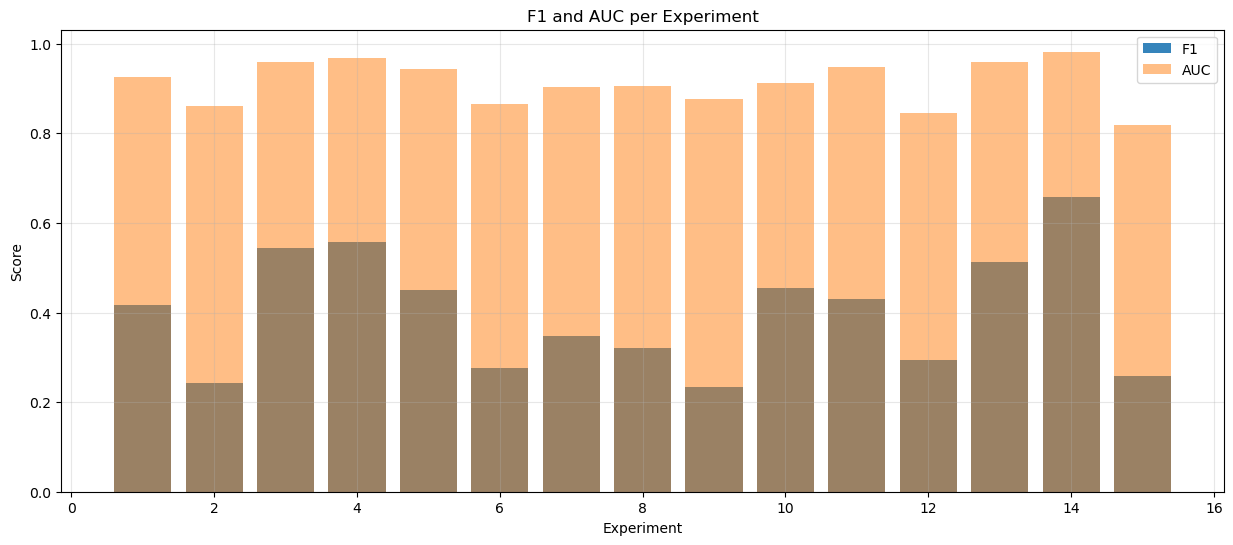

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.bar(df["experiment"], df["avg_f1"], label="F1", alpha=0.9)
plt.bar(df["experiment"], df["avg_auc"], label="AUC", alpha=0.5)
plt.xlabel("Experiment")
plt.ylabel("Score")
plt.title("F1 and AUC per Experiment")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

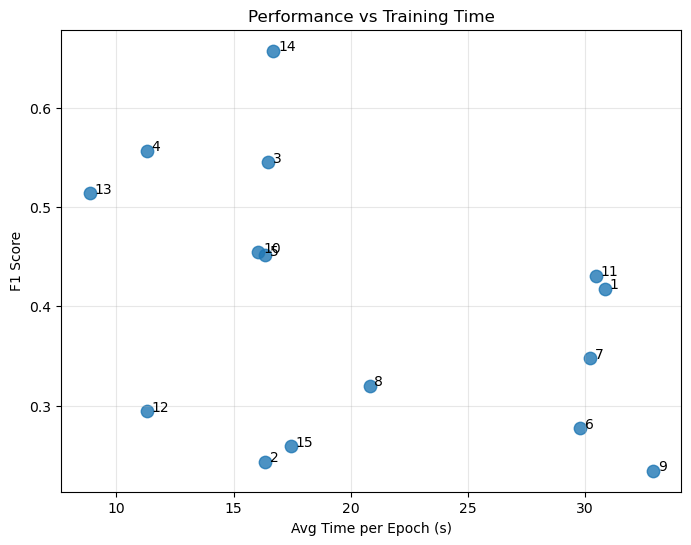

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(df["avg_time_per_epoch"], df["avg_f1"], s=80, alpha=0.8)
plt.xlabel("Avg Time per Epoch (s)")
plt.ylabel("F1 Score")
plt.title("Performance vs Training Time")
plt.grid(alpha=0.3)
for i, row in df.iterrows():
    plt.text(row["avg_time_per_epoch"]+0.2, row["avg_f1"], str(int(row["experiment"])))
plt.show()

# Model Selection
As shown in the result of 16 random search across a 5-fold Stratified Cross-Validation, Experiment 14 achieved the highest mean f1 score (0.657190) with high accuracy score of 0.982316 and efficient convergence.

This configuration provides the best balance between model accuracy and computational efficiency and was therefore selected as the final model for retraining on the combined dataset

# Get the best model configuration. 

In [10]:
import json

RESULTS_PATH = "cnn_random_search/results.json"
TARGET_EXP = 14

with open(RESULTS_PATH, "r", encoding="utf-8") as f:
    results = json.load(f) 

rec = next((r for r in results if r.get("experiment") == TARGET_EXP), None)
if rec is None:
    raise ValueError(f"Experiment {TARGET_EXP} not found in {RESULTS_PATH}")

params = {k: v for k, v in rec.items() if k not in ("experiment", "fold_metrics")}

print("Params for experiment", TARGET_EXP)
for k, v in params.items():
    print(f"{k}: {v}")

Params for experiment 14
weight_decay: 0.00031622776601683794
use_batch_norm: True
pool_kernel_sizes: [2, 2, 2]
optimizer: Adam
momentum: None
learning_rate: 0.0005623413251903491
kernel_sizes: [5, 5, 3]
fc_hidden_dim: 256
dropout: 0.2
conv_channels: [64, 128, 256]
batch_size: 128


# Train Final CNN Model

In [12]:
from utils.data_augmentation import augment_batch
import numpy as np
from sklearn.model_selection import train_test_split
data_path = "data/ecg_preprocessed_train_val.npz"
data = np.load(data_path)

X = data["X"]
y = data["y"]


# Create a train val split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.05,random_state=42,stratify=y)
augmented_data = augment_batch(X_train)
merged_X_train = np.concatenate([X_train, augmented_data], axis=0) 
print(merged_X_train.shape)

(166352, 187)


In [13]:
merged_y_train = np.concatenate([y_train, y_train], axis=0) 
print(merged_y_train.shape)

(166352,)


In [15]:
train_dataset = ECG_Dataset(merged_X_train, merged_y_train)
val_dataset = ECG_Dataset(X_val, y_val)

_, class_weights = calculate_class_weights(y_train)
train_sample_weights = np.array(class_weights)[y_train]

weighted_sampler = WeightedRandomSampler(
    weights=train_sample_weights,
    num_samples=len(train_sample_weights),
    replacement=True,
)


In [22]:
PATIENCE = 12
DELTA = 1e-4

LR_PATIENCE = 6
MIN_LR = 1e-4
FACTOR = 0.5

GRAD_CLIP = True
MAX_NORM = 1.0

EPOCHS = 100
CHECKPOINT_PATH = "models/best_CNN.pt"

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ECG_CNN_Classifier(
    num_classes=NUM_CLASSES,
    in_channels=1,
    conv_channels=tuple(params["conv_channels"]),
    kernel_sizes=tuple(params["kernel_sizes"]),
    pool_kernel_sizes=tuple(params["pool_kernel_sizes"]),
    dropout=float(params["dropout"]),
    fc_hidden_dim=params["fc_hidden_dim"],
    use_batch_norm=bool(params["use_batch_norm"]),
).to(device)

model.to(device)

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=params["learning_rate"],
    weight_decay=params["weight_decay"],
)
loss_fn = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=FACTOR,
    patience=LR_PATIENCE,
    min_lr=MIN_LR,
)

early_stopper = EarlyStopping(
    patience=PATIENCE,
    delta=DELTA,
    checkpoint_path=CHECKPOINT_PATH,
    verbose=True,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=params["batch_size"],
    sampler=weighted_sampler,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True,
)

train_history = train_and_eval_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=EPOCHS,
    device=device,
    early_stopper=early_stopper,
    scheduler=lr_scheduler,
    debug=True,
    verbose=True,
    grad_clip=GRAD_CLIP,
    max_norm=MAX_NORM,
)


Training:   0%|          | 0/650 [00:22<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:22<?, ?it/s]

Validation loss decreased ( inf -->  1.2740)
Epoch 1 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.491 | Val Loss:  1.274
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 2 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.318 | Val Loss:  1.864
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 3 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.267 | Val Loss:  1.784
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 4 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.235 | Val Loss:  1.523
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 12
Epoch 5 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.211 | Val Loss:  1.865
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 12
Epoch 6 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.195 | Val Loss:  1.482
Best Val Loss:  1.274
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 1.2740 -->  1.1642)
Epoch 7 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.183 | Val Loss:  1.164
Best Val Loss:  1.164
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 1.1642 -->  0.7276)
Epoch 8 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.164 | Val Loss:  0.728
Best Val Loss:  0.728
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 9 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.156 | Val Loss:  1.168
Best Val Loss:  0.728
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 10 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.148 | Val Loss:  1.108
Best Val Loss:  0.728
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.7276 -->  0.6439)
Epoch 11 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.140 | Val Loss:  0.644
Best Val Loss:  0.644
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 12 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.132 | Val Loss:  0.897
Best Val Loss:  0.644
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 13 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.130 | Val Loss:  0.820
Best Val Loss:  0.644
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 14 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.122 | Val Loss:  1.044
Best Val Loss:  0.644
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 12
Epoch 15 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.117 | Val Loss:  0.787
Best Val Loss:  0.644
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 12
Epoch 16 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.113 | Val Loss:  0.885
Best Val Loss:  0.644
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.6439 -->  0.3787)
Epoch 17 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.108 | Val Loss:  0.379
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 18 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.100 | Val Loss:  1.138
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 19 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.100 | Val Loss:  0.793
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 20 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.095 | Val Loss:  0.788
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 12
Epoch 21 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.093 | Val Loss:  0.777
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 12
Epoch 22 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.092 | Val Loss:  0.649
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 12
Epoch 23 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.087 | Val Loss:  0.622
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 7 / 12
Epoch 24 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.083 | Val Loss:  0.520
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 8 / 12
Epoch 25 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.073 | Val Loss:  0.442
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 9 / 12
Epoch 26 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.070 | Val Loss:  0.577
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 10 / 12
Epoch 27 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.066 | Val Loss:  0.514
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 11 / 12
Epoch 28 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.067 | Val Loss:  0.526
Best Val Loss:  0.379
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 12 / 12
Epoch 29 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.062 | Val Loss:  0.444
Best Val Loss:  0.379
-------------------------------------------------
Stopping Early at epoch 29 ! Val Loss has not improved for 12 epochs
-------------------------------------------------


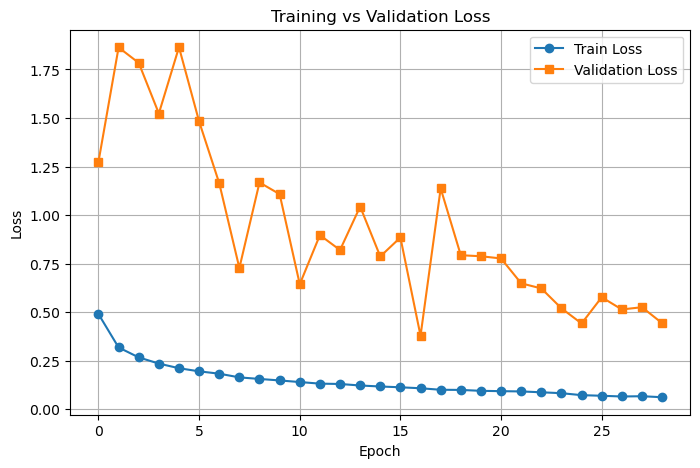

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train Loss", marker="o")
plt.plot(train_history["val_loss"], label="Validation Loss", marker="s")

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Prepare the test dataset
TEST_DATA_PATH = "data/mitbih_test.csv"
test_df = pd.read_csv(TEST_DATA_PATH)
X_test, y_test = split_x_y(test_df)

preprocess = Preprocessing(
    sample_freq=125,
    cutoff_freq=25,
    order=3,
    target_r_peak_index=94,
    method="neurokit",
)

X_test_preprocessed = preprocess.transform(X_test)

test_dataset = ECG_Dataset(X_test_preprocessed, y_test)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True,
)


Applying Low-Pass Filter ...


Applying Low Pass Filter:   0%|          | 0/21891 [00:00<?, ?it/s]

Perforing R-Peak Realignment ... 


  0%|          | 0/21891 [00:00<?, ?it/s]

C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\P

Completed Preprocessing


In [38]:
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device)["model_state_dict"])
model.to(device)

test_results = test_loop(model=model, test_dataloader=test_dataloader, device=device)

y_pred = test_results["y_pred"]
y_true = test_results["y_true"]


Testing:   0%|          | 0/172 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           N     0.9890    0.8663    0.9236     18117
           S     0.1651    0.9101    0.2796       556
           V     0.9041    0.8467    0.8745      1448
           F     0.8684    0.4074    0.5546       162
           Q     0.9928    0.9428    0.9671      1608

    accuracy                         0.8683     21891
   macro avg     0.7839    0.7946    0.7199     21891
weighted avg     0.9619    0.8683    0.9044     21891



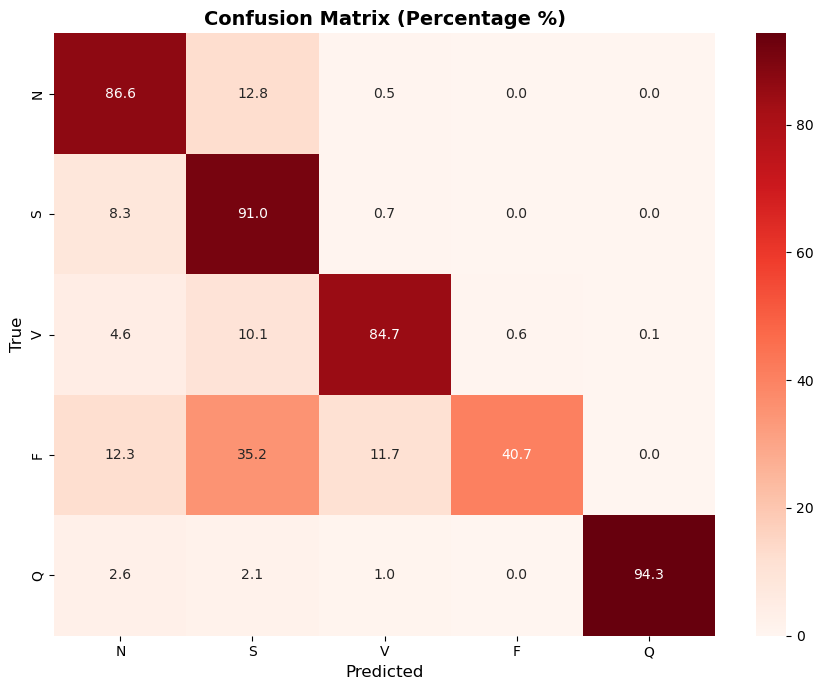

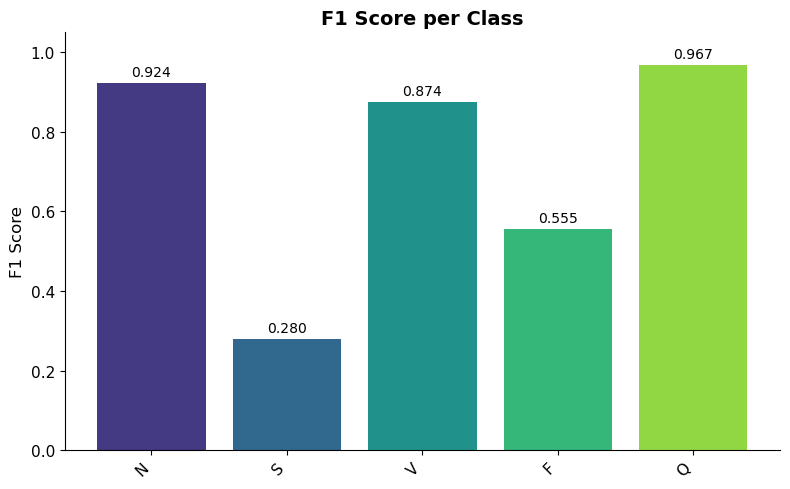

In [44]:
labels_list = ["N", "S", "V", "F", "Q"]
print(
    classification_report(
        y_true,
        y_pred,
        target_names=labels_list,
        digits=4,
    )
)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to percentages (row-wise normalization)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(9,7))

sns.heatmap(cm_percent,
            annot=True,
            fmt=".1f",          # one decimal place
            cmap="Reds",
            xticklabels=labels_list,
            yticklabels=labels_list)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix (Percentage %)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


f1_per_class = f1_score(y_true, y_pred, average=None)

plt.figure(figsize=(8,5))

palette = sns.color_palette("viridis", len(labels_list))

bars = plt.bar(labels_list, f1_per_class, color=palette)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f"{height:.3f}",
             ha="center", va="bottom", fontsize=10)

plt.title("F1 Score per Class", fontsize=14, fontweight="bold")
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0, 1.05)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()


# Train model with best config on original ECG training dataset 

In [62]:
data_path = "data/ecg_preprocessed_train_val.npz"
data = np.load(data_path)

X = data["X"]
y = data["y"]


# Create a train val split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = ECG_Dataset(X_train, y_train)
val_dataset = ECG_Dataset(X_val, y_val)

_, class_weights = calculate_class_weights(y_train)
train_sample_weights = np.array(class_weights)[y_train]

weighted_sampler = WeightedRandomSampler(
    weights=train_sample_weights,
    num_samples=len(train_sample_weights),
    replacement=True,
)

PATIENCE = 12
DELTA = 1e-4

LR_PATIENCE = 6
MIN_LR = 1e-4
FACTOR = 0.5

GRAD_CLIP = True
MAX_NORM = 1.0

EPOCHS = 100
CHECKPOINT_PATH2 = "models/best_CNN_original_data.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

model_orgin_data = ECG_CNN_Classifier(
    num_classes=NUM_CLASSES,
    in_channels=1,
    conv_channels=tuple(params["conv_channels"]),
    kernel_sizes=tuple(params["kernel_sizes"]),
    pool_kernel_sizes=tuple(params["pool_kernel_sizes"]),
    dropout=float(params["dropout"]),
    fc_hidden_dim=params["fc_hidden_dim"],
    use_batch_norm=bool(params["use_batch_norm"]),
).to(device)

model_orgin_data.to(device)

optimizer = torch.optim.AdamW(
    params=model_orgin_data.parameters(),
    lr=params["learning_rate"],
    weight_decay=params["weight_decay"],
)
loss_fn = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=FACTOR,
    patience=LR_PATIENCE,
    min_lr=MIN_LR,
)

early_stopper = EarlyStopping(
    patience=PATIENCE,
    delta=DELTA,
    checkpoint_path=CHECKPOINT_PATH2,
    verbose=True,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=params["batch_size"],
    sampler=weighted_sampler,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True,
)

train_history = train_and_eval_model(
    model=model_orgin_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=EPOCHS,
    device=device,
    early_stopper=early_stopper,
    scheduler=lr_scheduler,
    debug=True,
    verbose=True,
    grad_clip=GRAD_CLIP,
    max_norm=MAX_NORM,
)


Training:   0%|          | 0/650 [00:26<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:21<?, ?it/s]

Validation loss decreased ( inf -->  1.4325)
Epoch 1 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.511 | Val Loss:  1.433
Best Val Loss:  1.433
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 1.4325 -->  1.1056)
Epoch 2 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.334 | Val Loss:  1.106
Best Val Loss:  1.106
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 3 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.280 | Val Loss:  1.282
Best Val Loss:  1.106
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 4 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.242 | Val Loss:  1.229
Best Val Loss:  1.106
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 1.1056 -->  0.6699)
Epoch 5 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.218 | Val Loss:  0.670
Best Val Loss:  0.670
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 6 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.199 | Val Loss:  1.051
Best Val Loss:  0.670
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 7 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.185 | Val Loss:  0.693
Best Val Loss:  0.670
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 8 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.173 | Val Loss:  0.711
Best Val Loss:  0.670
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.6699 -->  0.5802)
Epoch 9 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.163 | Val Loss:  0.580
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 10 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.155 | Val Loss:  0.618
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 11 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.145 | Val Loss:  1.057
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 12 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.140 | Val Loss:  0.785
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 12
Epoch 13 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.129 | Val Loss:  0.587
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 12
Epoch 14 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.125 | Val Loss:  0.878
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 12
Epoch 15 / 100 | Current LR: 0.0005623413251903491
Train Loss:  0.121 | Val Loss:  1.147
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 7 / 12
Epoch 16 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.115 | Val Loss:  0.895
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 8 / 12
Epoch 17 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.098 | Val Loss:  0.613
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 9 / 12
Epoch 18 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.095 | Val Loss:  0.888
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 10 / 12
Epoch 19 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.091 | Val Loss:  0.649
Best Val Loss:  0.580
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.5802 -->  0.4703)
Epoch 20 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.087 | Val Loss:  0.470
Best Val Loss:  0.470
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 21 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.085 | Val Loss:  0.680
Best Val Loss:  0.470
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 22 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.086 | Val Loss:  0.636
Best Val Loss:  0.470
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 23 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.080 | Val Loss:  0.678
Best Val Loss:  0.470
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 12
Epoch 24 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.081 | Val Loss:  0.711
Best Val Loss:  0.470
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.4703 -->  0.4618)
Epoch 25 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.080 | Val Loss:  0.462
Best Val Loss:  0.462
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 26 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.079 | Val Loss:  0.754
Best Val Loss:  0.462
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.4618 -->  0.4537)
Epoch 27 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.074 | Val Loss:  0.454
Best Val Loss:  0.454
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 28 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.072 | Val Loss:  0.742
Best Val Loss:  0.454
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 29 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.071 | Val Loss:  0.602
Best Val Loss:  0.454
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 30 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.072 | Val Loss:  0.580
Best Val Loss:  0.454
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss decreased ( 0.4537 -->  0.2972)
Epoch 31 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.072 | Val Loss:  0.297
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 1 / 12
Epoch 32 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.066 | Val Loss:  0.597
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 2 / 12
Epoch 33 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.067 | Val Loss:  0.680
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 3 / 12
Epoch 34 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.067 | Val Loss:  0.403
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 4 / 12
Epoch 35 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.062 | Val Loss:  0.637
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 5 / 12
Epoch 36 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.066 | Val Loss:  0.646
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 6 / 12
Epoch 37 / 100 | Current LR: 0.00028117066259517455
Train Loss:  0.063 | Val Loss:  0.425
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 7 / 12
Epoch 38 / 100 | Current LR: 0.00014058533129758727
Train Loss:  0.063 | Val Loss:  0.471
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 8 / 12
Epoch 39 / 100 | Current LR: 0.00014058533129758727
Train Loss:  0.057 | Val Loss:  0.414
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 9 / 12
Epoch 40 / 100 | Current LR: 0.00014058533129758727
Train Loss:  0.054 | Val Loss:  0.426
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 10 / 12
Epoch 41 / 100 | Current LR: 0.00014058533129758727
Train Loss:  0.055 | Val Loss:  0.344
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 11 / 12
Epoch 42 / 100 | Current LR: 0.00014058533129758727
Train Loss:  0.053 | Val Loss:  0.396
Best Val Loss:  0.297
-------------------------------------------------


Training:   0%|          | 0/650 [00:00<?, ?it/s]

Classes Predicted: tensor([0, 1, 2, 3, 4], device='cuda:0')


Validation:   0%|          | 0/35 [00:00<?, ?it/s]

Early Stopping Counter: 12 / 12
Epoch 43 / 100 | Current LR: 0.00014058533129758727
Train Loss:  0.052 | Val Loss:  0.567
Best Val Loss:  0.297
-------------------------------------------------
Stopping Early at epoch 43 ! Val Loss has not improved for 12 epochs
-------------------------------------------------


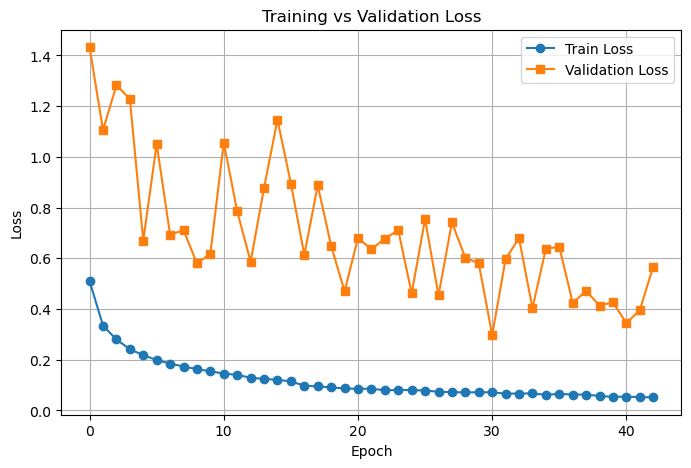

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train Loss", marker="o")
plt.plot(train_history["val_loss"], label="Validation Loss", marker="s")

plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Prepare the test dataset
TEST_DATA_PATH = "data/mitbih_test.csv"
test_df = pd.read_csv(TEST_DATA_PATH)
X_test, y_test = split_x_y(test_df)

preprocess = Preprocessing(
    sample_freq=125,
    cutoff_freq=25,
    order=3,
    target_r_peak_index=94,
    method="neurokit",
)

X_test_preprocessed = preprocess.transform(X_test)

test_dataset = ECG_Dataset(X_test_preprocessed, y_test)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    pin_memory=True,
)

model_orgin_data.load_state_dict(torch.load(CHECKPOINT_PATH2, map_location=device)["model_state_dict"])
model_orgin_data.to(device)

test_results = test_loop(model=model_orgin_data, test_dataloader=test_dataloader, device=device)

test_pred = test_results["y_pred"]
test_true = test_results["y_true"]

labels_list = ["N", "S", "V", "F", "Q"]
print(
    classification_report(
        test_true,
        test_pred,
        target_names=labels_list,
        digits=4,
    )
)


Applying Low-Pass Filter ...


Applying Low Pass Filter:   0%|          | 0/21891 [00:00<?, ?it/s]

Perforing R-Peak Realignment ... 


  0%|          | 0/21891 [00:00<?, ?it/s]

C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\P

Completed Preprocessing


Testing:   0%|          | 0/172 [00:17<?, ?it/s]

              precision    recall  f1-score   support

           N     0.9886    0.8790    0.9306     18117
           S     0.1904    0.8255    0.3094       556
           V     0.7761    0.9047    0.8355      1448
           F     0.8986    0.3827    0.5368       162
           Q     0.9690    0.9726    0.9708      1608

    accuracy                         0.8826     21891
   macro avg     0.7645    0.7929    0.7166     21891
weighted avg     0.9521    0.8826    0.9086     21891



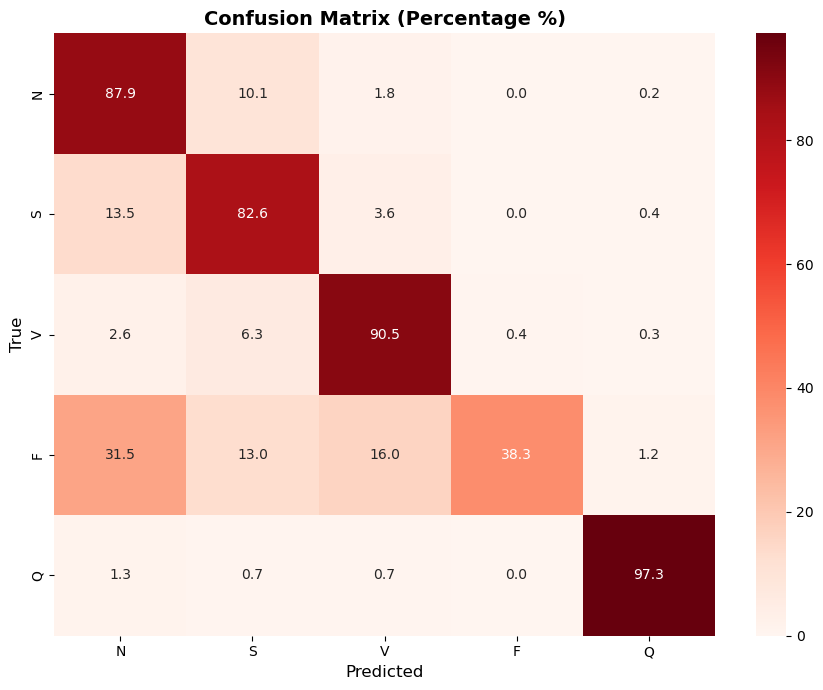

In [65]:
# Compute confusion matrix
cm = confusion_matrix(test_true, test_pred)

# Convert to percentages (row-wise normalization)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(9,7))

sns.heatmap(cm_percent,
            annot=True,
            fmt=".1f",          # one decimal place
            cmap="Reds",
            xticklabels=labels_list,
            yticklabels=labels_list)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix (Percentage %)", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

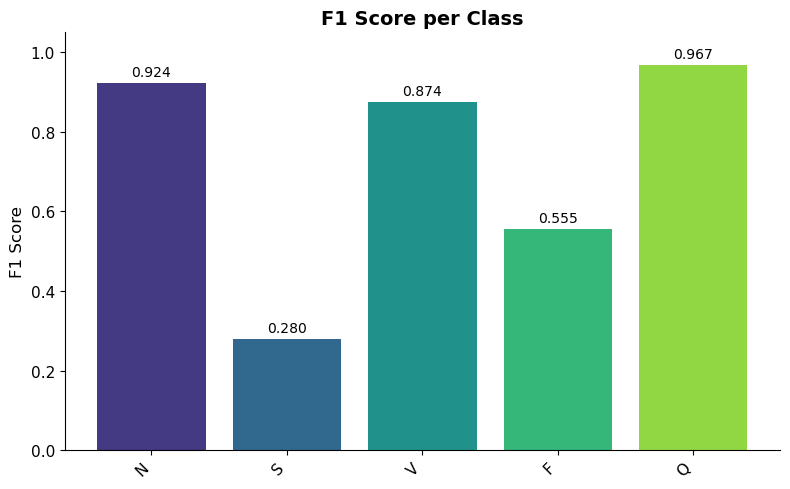

In [66]:
f1_per_class = f1_score(y_true, y_pred, average=None)

plt.figure(figsize=(8,5))

palette = sns.color_palette("viridis", len(labels_list))

bars = plt.bar(labels_list, f1_per_class, color=palette)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f"{height:.3f}",
             ha="center", va="bottom", fontsize=10)

plt.title("F1 Score per Class", fontsize=14, fontweight="bold")
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0, 1.05)

plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()
